# Cohort Revenue Retention Analysis: KT 

## Prepare Notebook

In [1]:
from datetime import date

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns
from mlforecast import MLForecast
from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoMFLES,
    SimpleExponentialSmoothingOptimized,
)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "hm_retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path = "/Users/juanitorduz/Dropbox/cohort-revenue-retention-paper/data/KT/kt.csv"
raw_df = pl.read_csv(
    data_path,
    # columns=["t_dat", "customer_id", "price"],
    try_parse_dates=True,
)

raw_df.head()

shape: (5, 5)
┌──────────┬──────────┬────────────┬───────┬───────┐
│ customer ┆ basket   ┆ date       ┆ store ┆ value │
│ ---      ┆ ---      ┆ ---        ┆ ---   ┆ ---   │
│ i64      ┆ i64      ┆ date       ┆ i64   ┆ f64   │
╞══════════╪══════════╪════════════╪═══════╪═══════╡
│ 1        ┆ 7395022  ┆ 2015-04-13 ┆ 82934 ┆ 4.35  │
│ 1        ┆ 9251168  ┆ 2015-04-15 ┆ 82535 ┆ 5.69  │
│ 1        ┆ 11386596 ┆ 2015-04-15 ┆ 82535 ┆ 3.76  │
│ 1        ┆ 5561542  ┆ 2015-05-02 ┆ 9     ┆ 12.27 │
│ 1        ┆ 15960613 ┆ 2015-05-16 ┆ 8     ┆ 51.35 │
└──────────┴──────────┴────────────┴───────┴───────┘

In [4]:
print(f"Date range: {raw_df['date'].min()} - {raw_df['date'].max()}")

Date range: 2015-04-09 - 2017-03-30


In [5]:
raw_df["customer"].n_unique()

562096

In [6]:
raw_df["store"].n_unique()

155

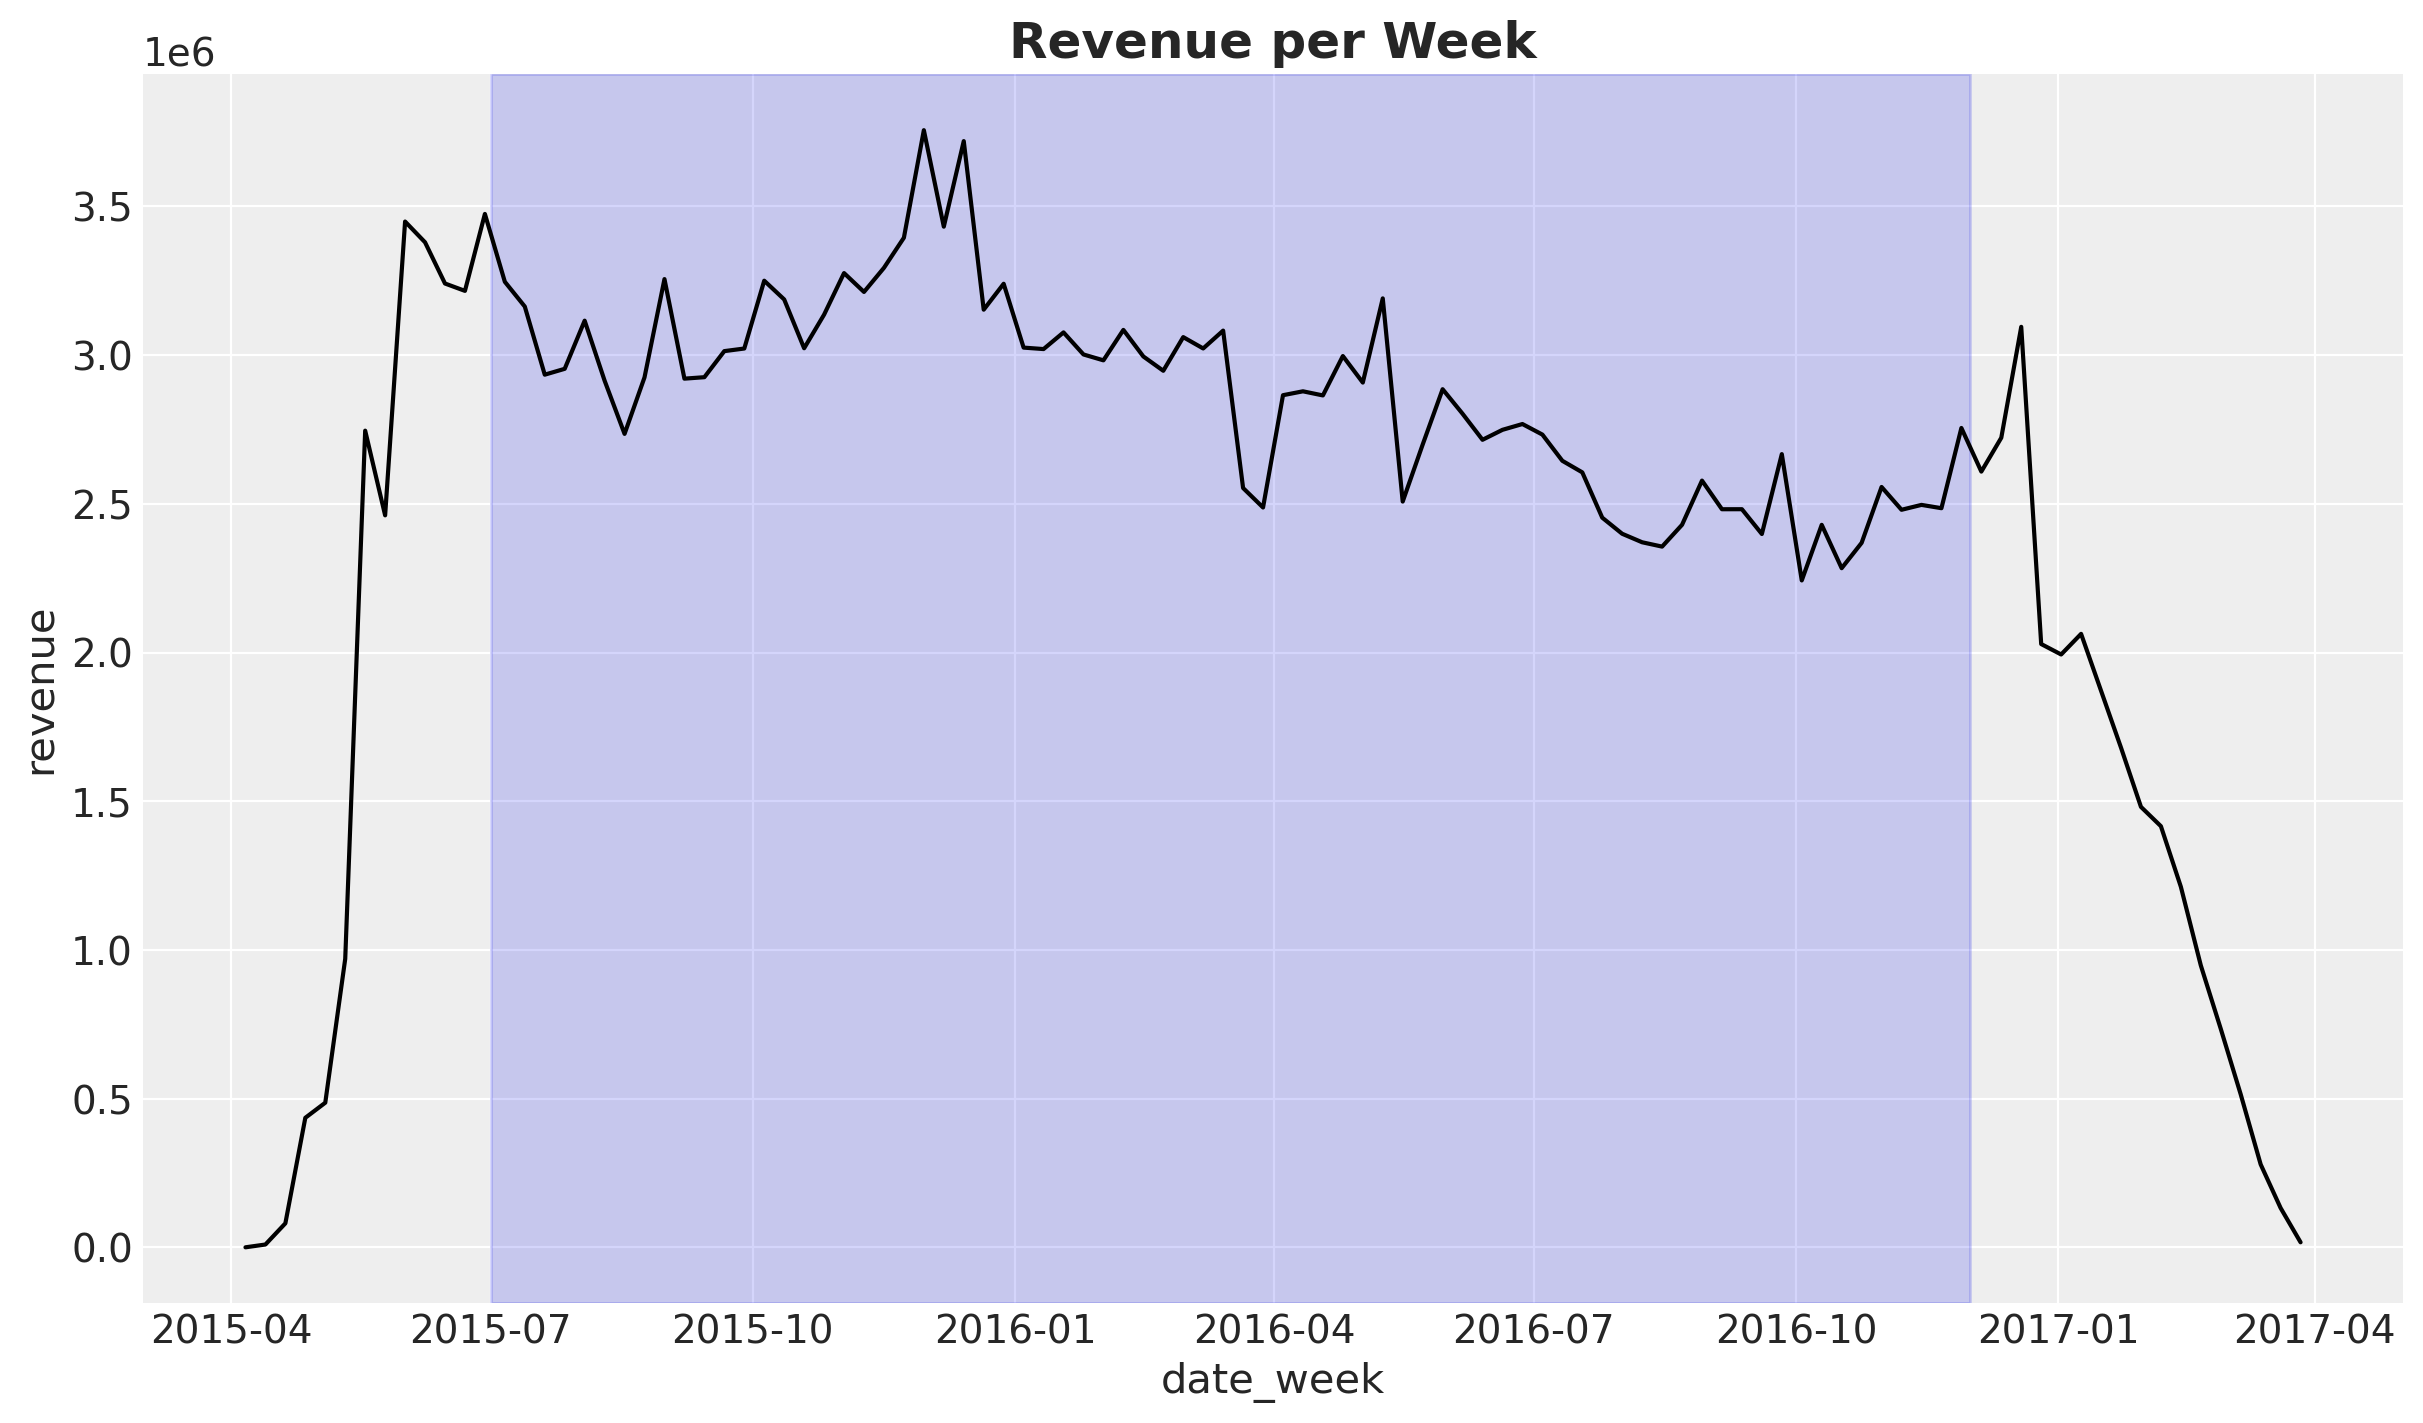

In [7]:
analysis_min_date = date(2015, 7, 1)
analysis_max_date = date(2016, 12, 1)

fig, ax = plt.subplots()
(
    raw_df.with_columns(pl.col("date").dt.truncate("1w").alias("date_week"))
    .group_by("date_week")
    .agg(pl.col("value").sum().alias("revenue"))
    .pipe(sns.lineplot, x="date_week", y="revenue", color="black", ax=ax)
)
ax.axvspan(
    analysis_min_date, analysis_max_date, color="C0", alpha=0.2, label="Analysis Period"
)
ax.set_title("Revenue per Week", fontsize=18, fontweight="bold");

## Data Preprocessing

We convert the Polars DataFrame to pandas for compatibility with PyMC and add derived columns.

In [8]:
customers_df = (
    raw_df.with_columns(
        pl.col("date").cast(pl.Date()).dt.truncate("1mo").alias("period"),
    )
    .group_by(["period", "customer"])
    .agg(pl.col("value").sum().alias("revenue"))
    .with_columns(pl.col("period").min().over(["customer"]).alias("cohort"))
    .with_columns(pl.col("customer").unique().len().over(["cohort"]).alias("n_users"))
    .sort(["cohort", "customer", "period"])
)

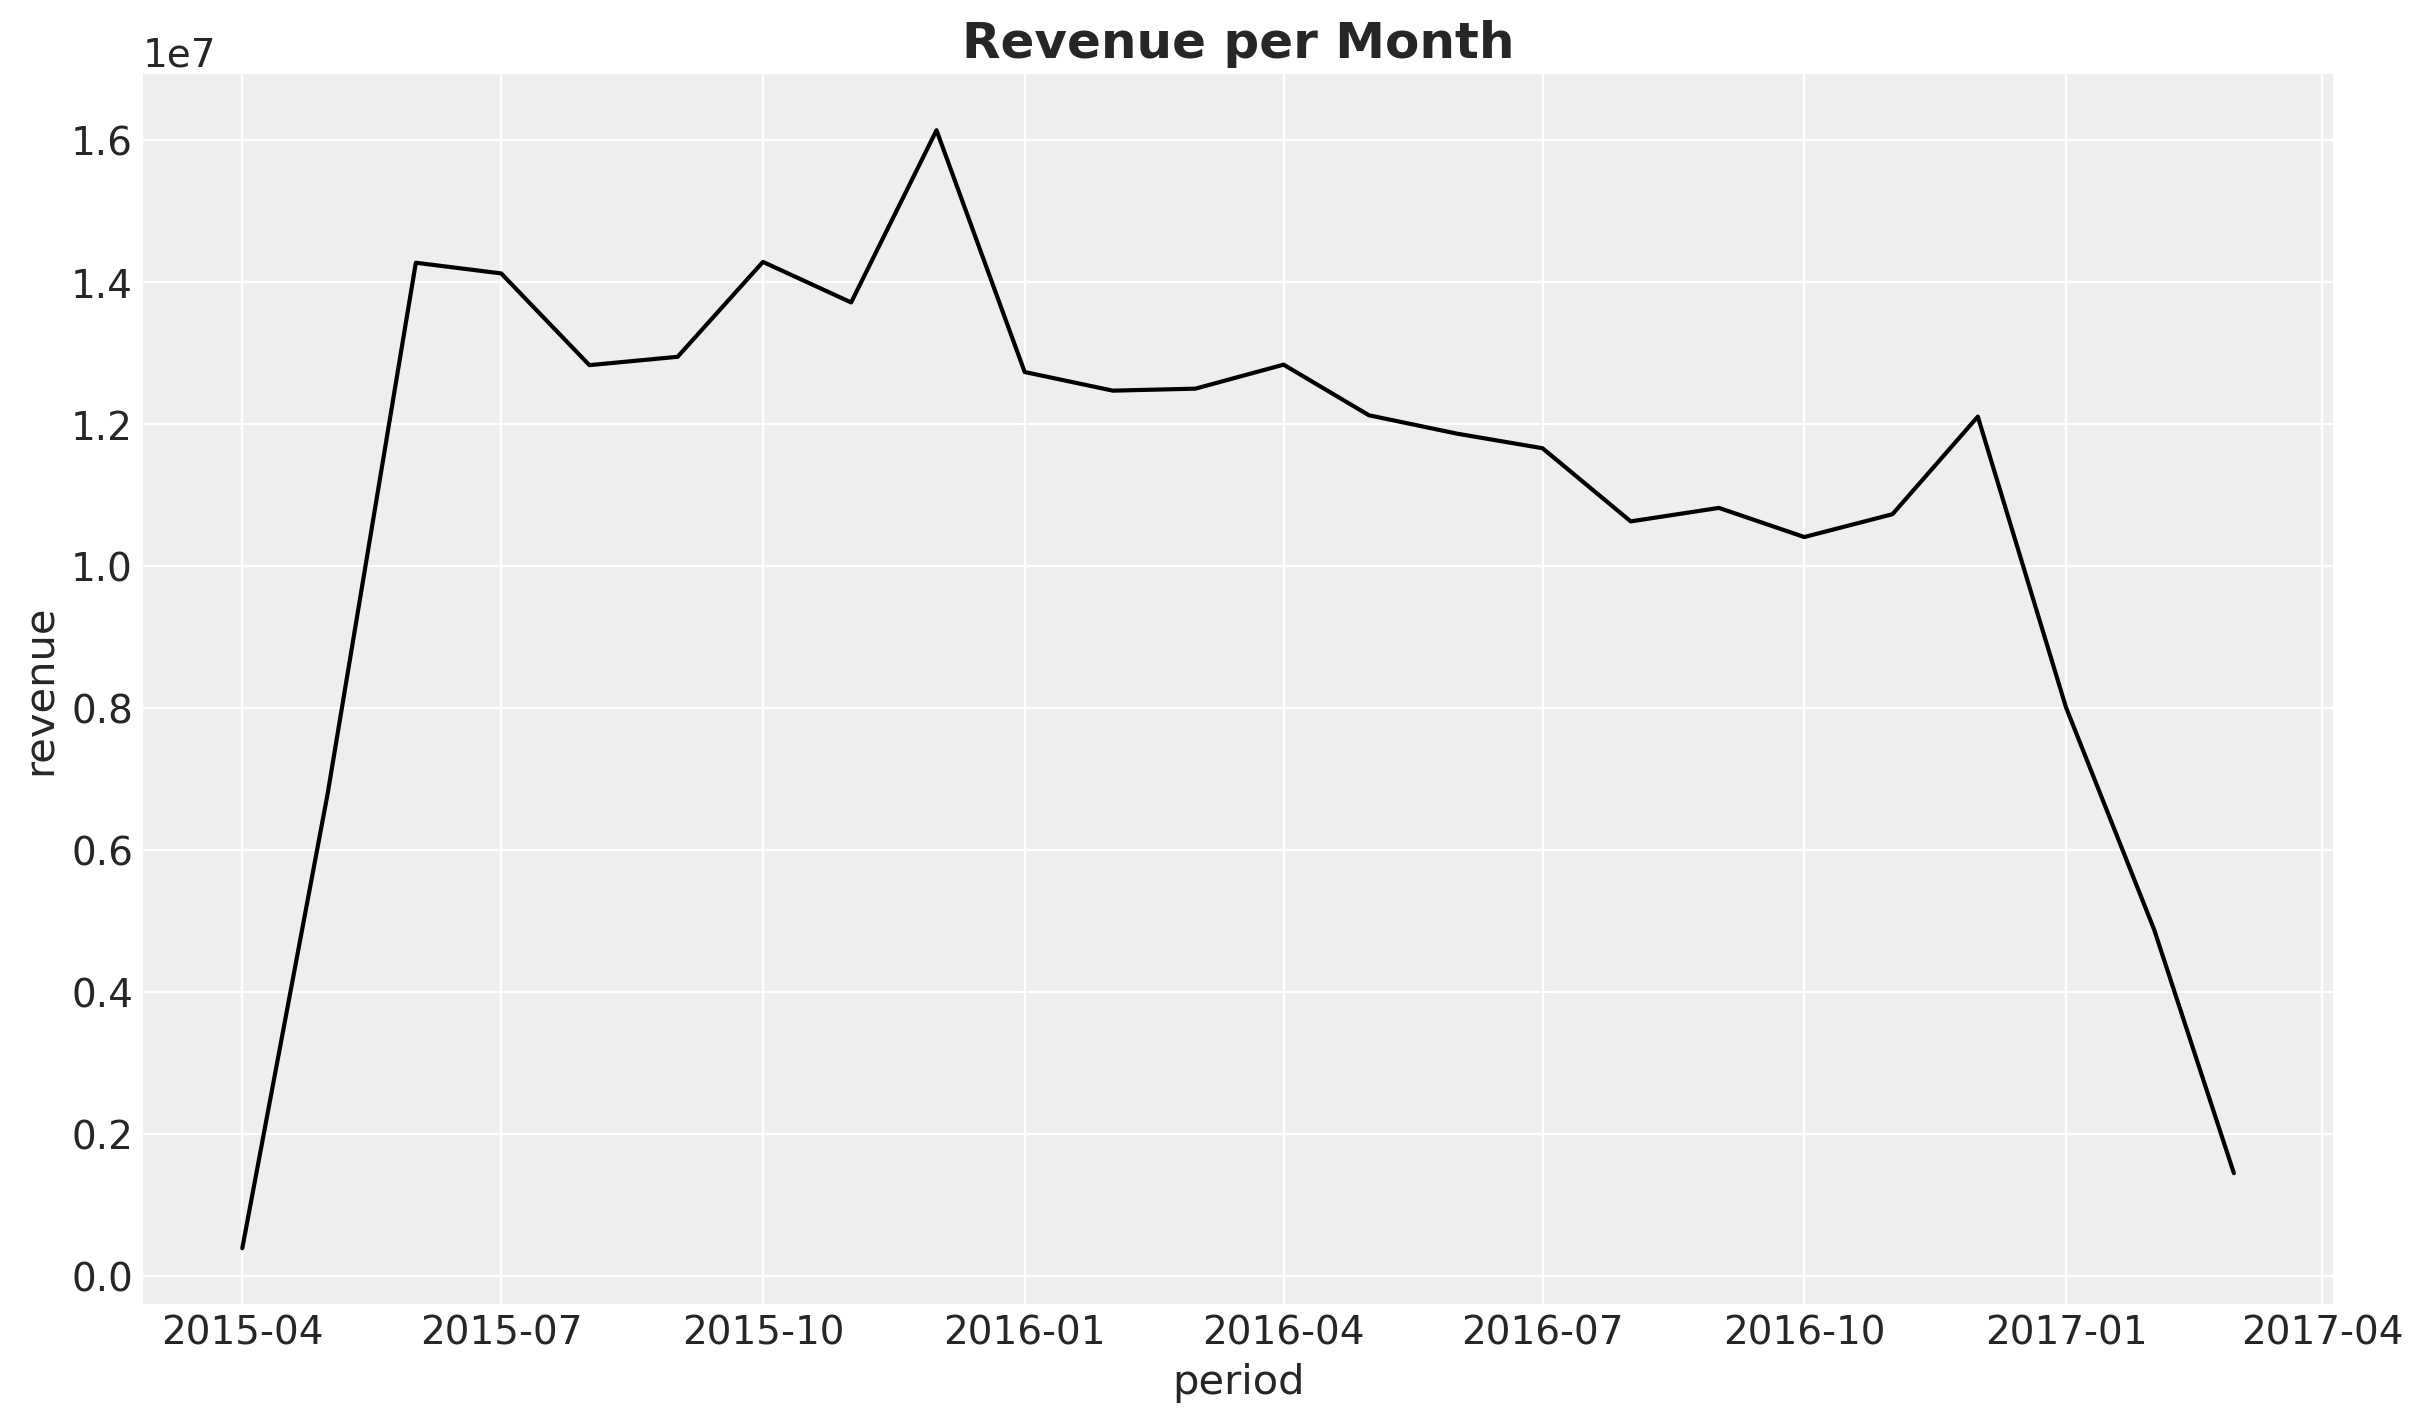

In [9]:
fig, ax = plt.subplots()
(
    customers_df.group_by("period")
    .agg(pl.col("revenue").sum().alias("revenue"))
    .pipe(sns.lineplot, x="period", y="revenue", color="black", ax=ax)
)
ax.set_title("Revenue per Month", fontsize=18, fontweight="bold");

In [10]:
cohort_df = (
    customers_df.group_by(["cohort", "period"])
    .agg(
        pl.col("revenue").sum(),
        pl.col("n_users").mean().cast(pl.Int64()),
        pl.col("customer").n_unique().cast(pl.Int64()).alias("n_active_users"),
    )
    .with_columns(
        pl.col("n_active_users").truediv(pl.col("n_users")).alias("retention"),
        (pl.col("period") - pl.col("cohort")).dt.total_days().alias("cohort_age"),
        (pl.col("period").max() - pl.col("period")).dt.total_days().alias("age"),
        (pl.col("revenue").truediv(pl.col("n_users"))).alias("revenue_per_users"),
        (pl.col("revenue").truediv(pl.col("n_active_users"))).alias(
            "revenue_per_active_users"
        ),
    )
    # Filter data so that we have complete months of data
    .filter(pl.col("cohort") >= analysis_min_date)
    .filter(pl.col("cohort") < analysis_max_date)
    .filter(pl.col("period") >= analysis_min_date)
    .filter(pl.col("period") < analysis_max_date)
)

In [11]:
assert cohort_df.null_count().to_series().sum() == 0

### Train-Test Split

We split the data into training and test sets based on a cutoff period.

In [12]:
period_train_test_split = date(2016, 8, 1)

train_data_df = cohort_df.filter(pl.col("period") <= period_train_test_split).sort(
    ["cohort", "period"]
)

test_data_df = (
    cohort_df.filter(pl.col("period") > period_train_test_split)
    .filter(pl.col("cohort").is_in(train_data_df["cohort"].unique().to_list()))
    .sort(["cohort", "period"])
)

print(f"Train data shape: {train_data_df.shape}")
print(f"Test data shape: {test_data_df.shape}")

Train data shape: (105, 10)
Test data shape: (42, 10)


## EDA

Let's explore the data to understand the retention and revenue patterns.

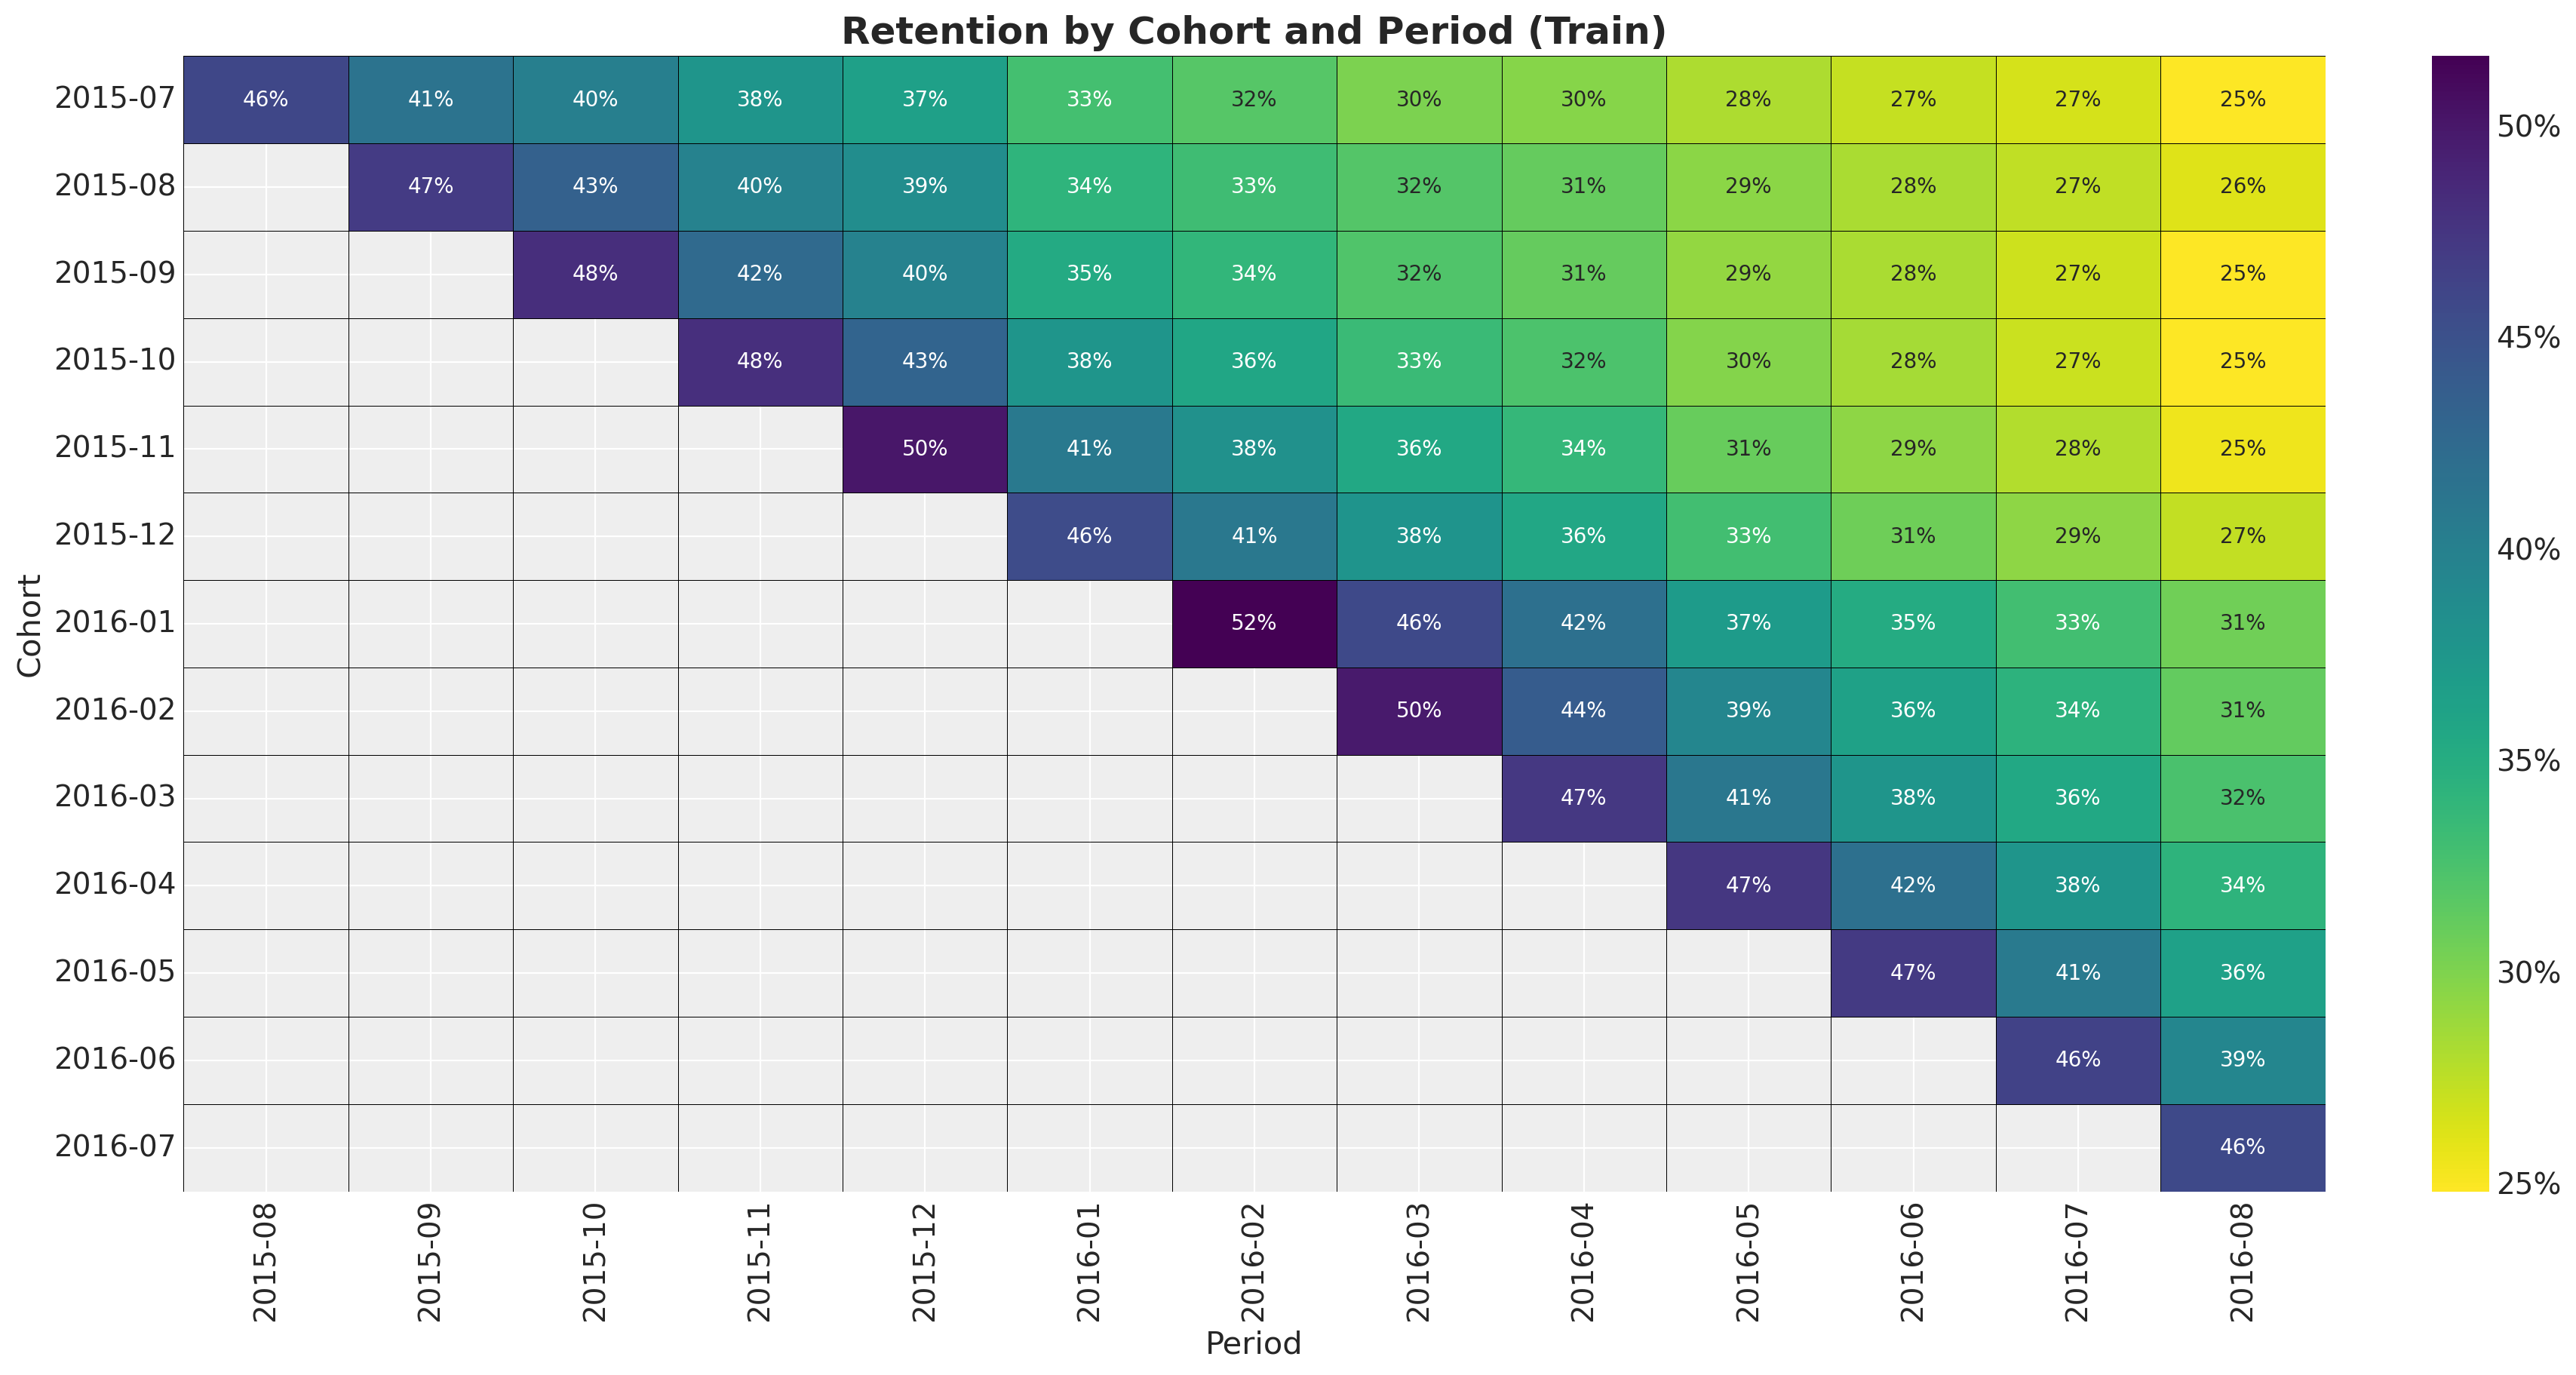

In [13]:
fig, ax = plt.subplots(figsize=(17, 9))

fmt = lambda y, _: f"{y:0.0%}"  # noqa: E731

(
    train_data_df.filter(pl.col("cohort_age") != 0)  # noqa: PD010
    .select(
        [
            pl.col("cohort").dt.strftime("%Y-%m").alias("cohort"),
            pl.col("period").dt.strftime("%Y-%m").alias("period"),
            pl.col("retention"),
        ]
    )
    .pivot(index="cohort", on="period", values="retention")
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.tick_params(axis="x", rotation=90)
ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Retention by Cohort and Period (Train)", fontsize=18, fontweight="bold");

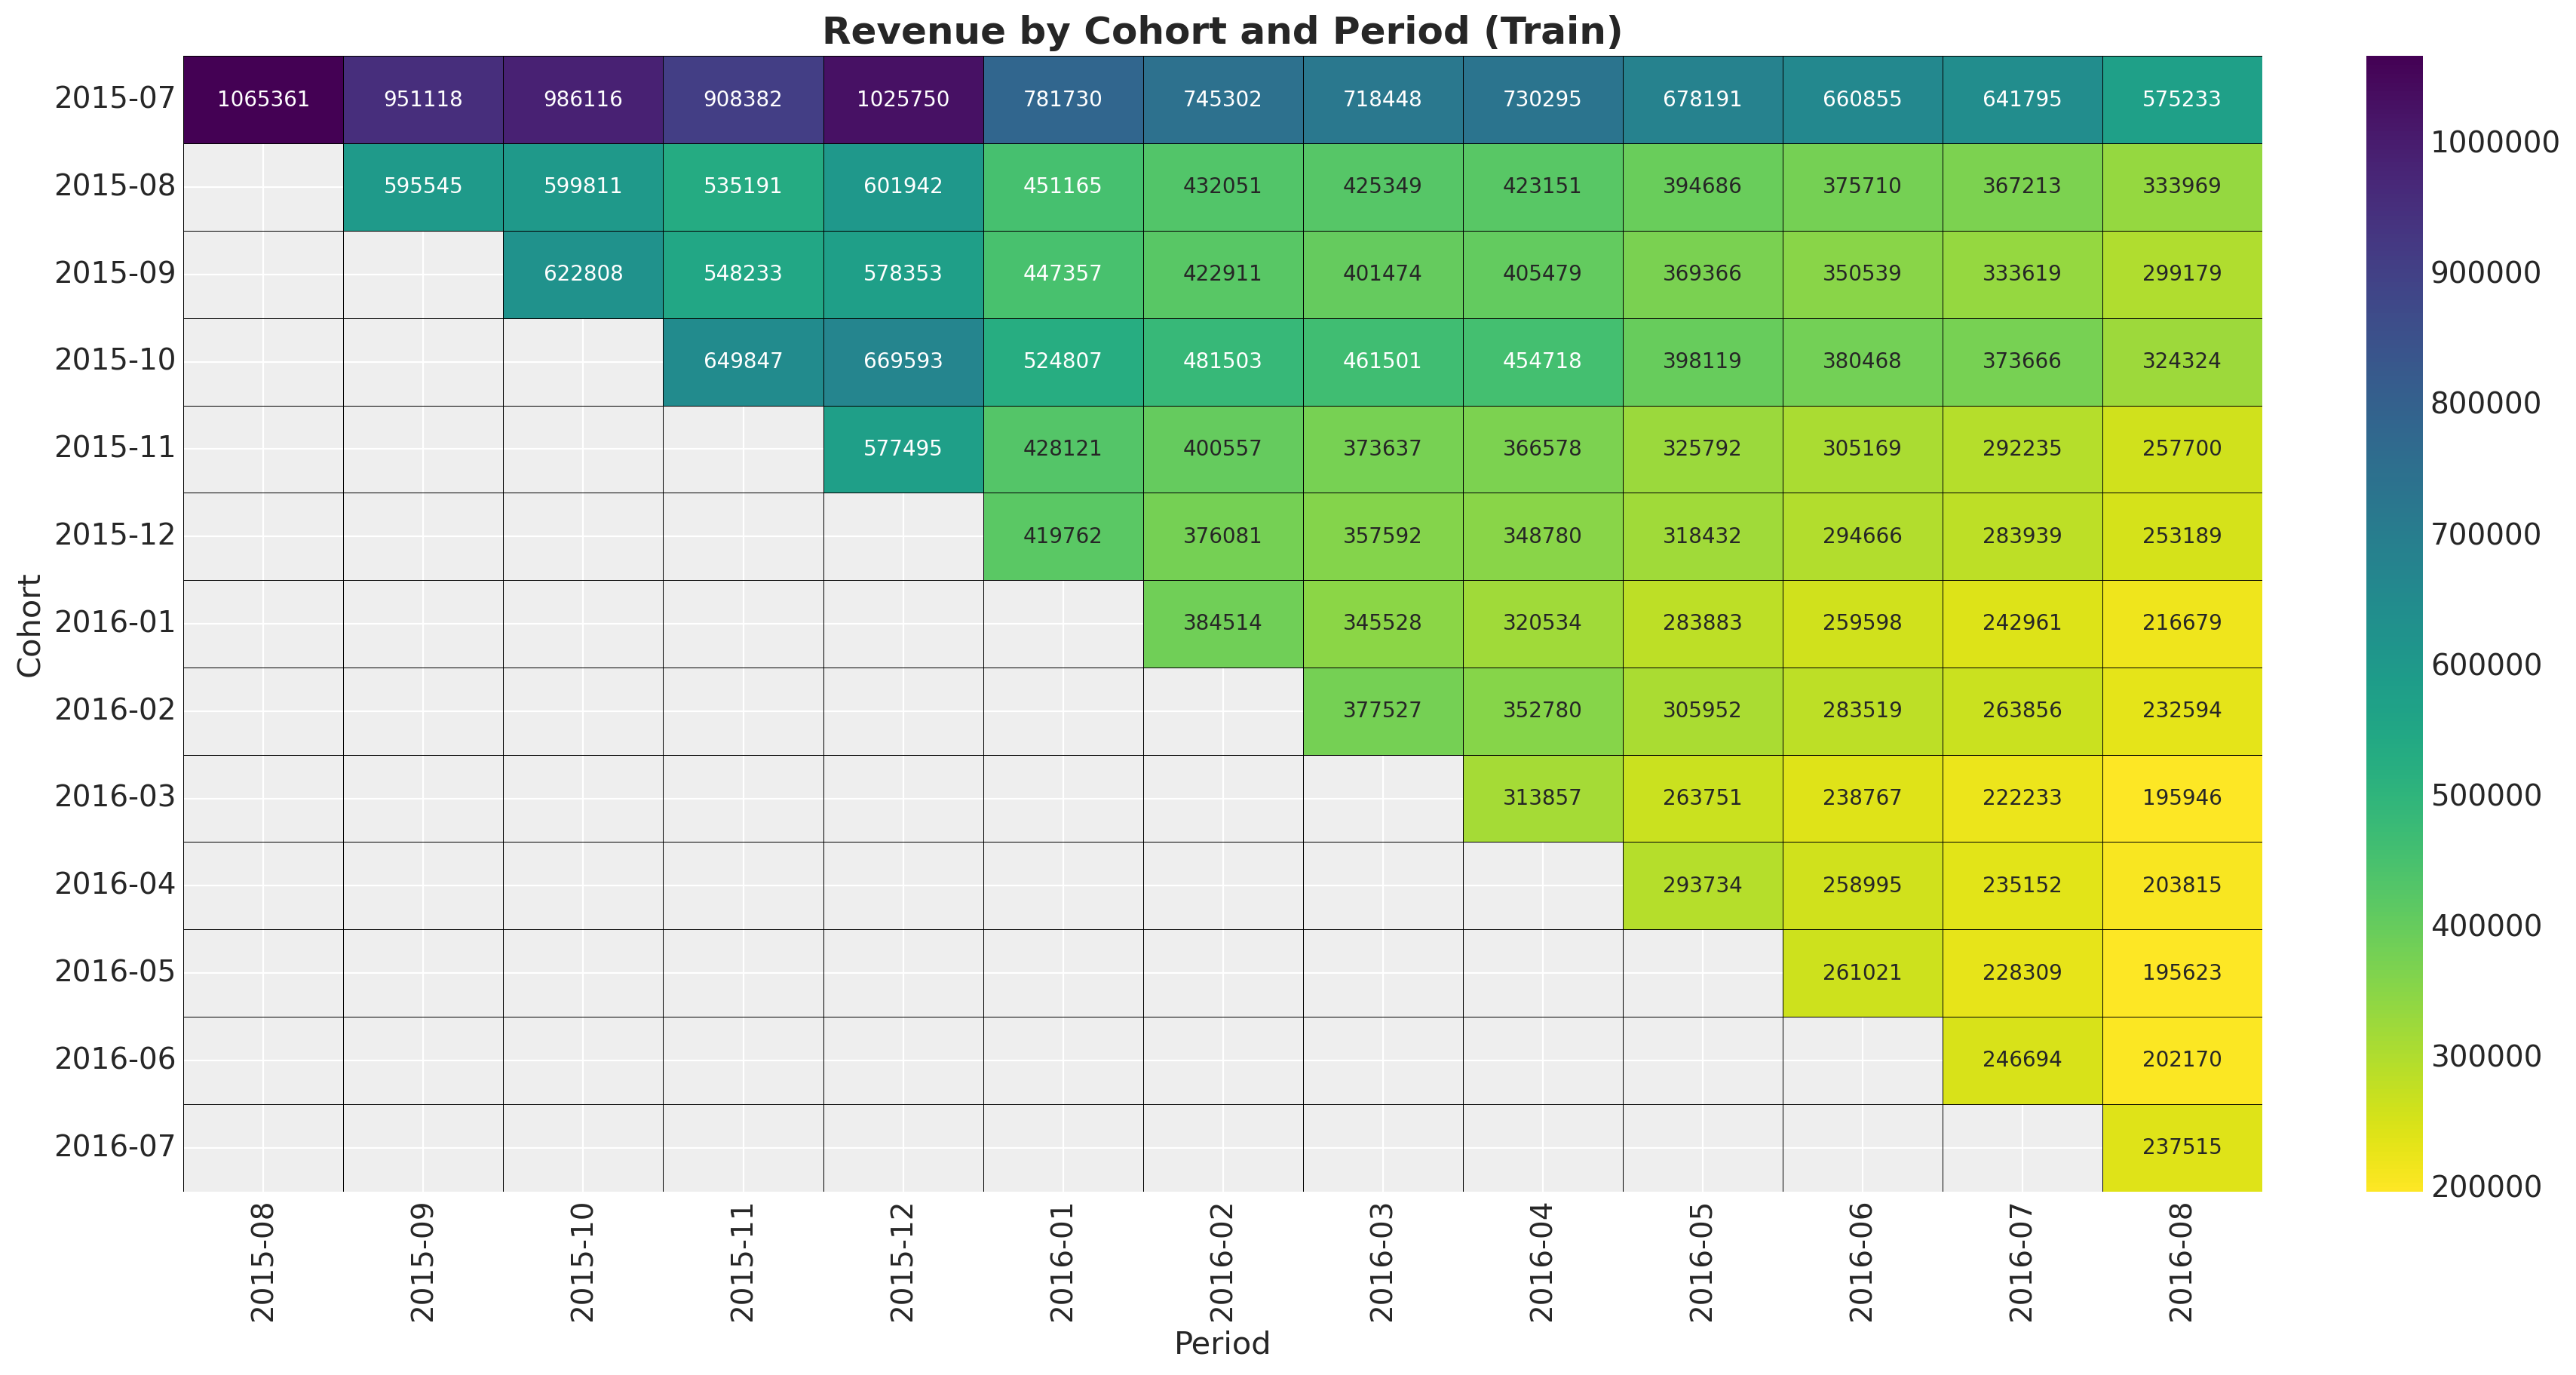

In [14]:
fig, ax = plt.subplots(figsize=(17, 9))

fmt = lambda y, _: f"{y:0.0f}"  # noqa: E731

(
    train_data_df.filter(pl.col("cohort_age") != 0)  # noqa: PD010
    .select(
        [
            pl.col("cohort").dt.strftime("%Y-%m").alias("cohort"),
            pl.col("period").dt.strftime("%Y-%m").alias("period"),
            pl.col("revenue"),
        ]
    )
    .pivot(index="cohort", on="period", values="revenue")
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0f",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)
ax.tick_params(axis="x", rotation=90)
ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Revenue by Cohort and Period (Train)", fontsize=18, fontweight="bold");

### Retention Rate by Cohort Over Time

We plot the retention rate by cohort over time to illustrate the seasonality pattern.

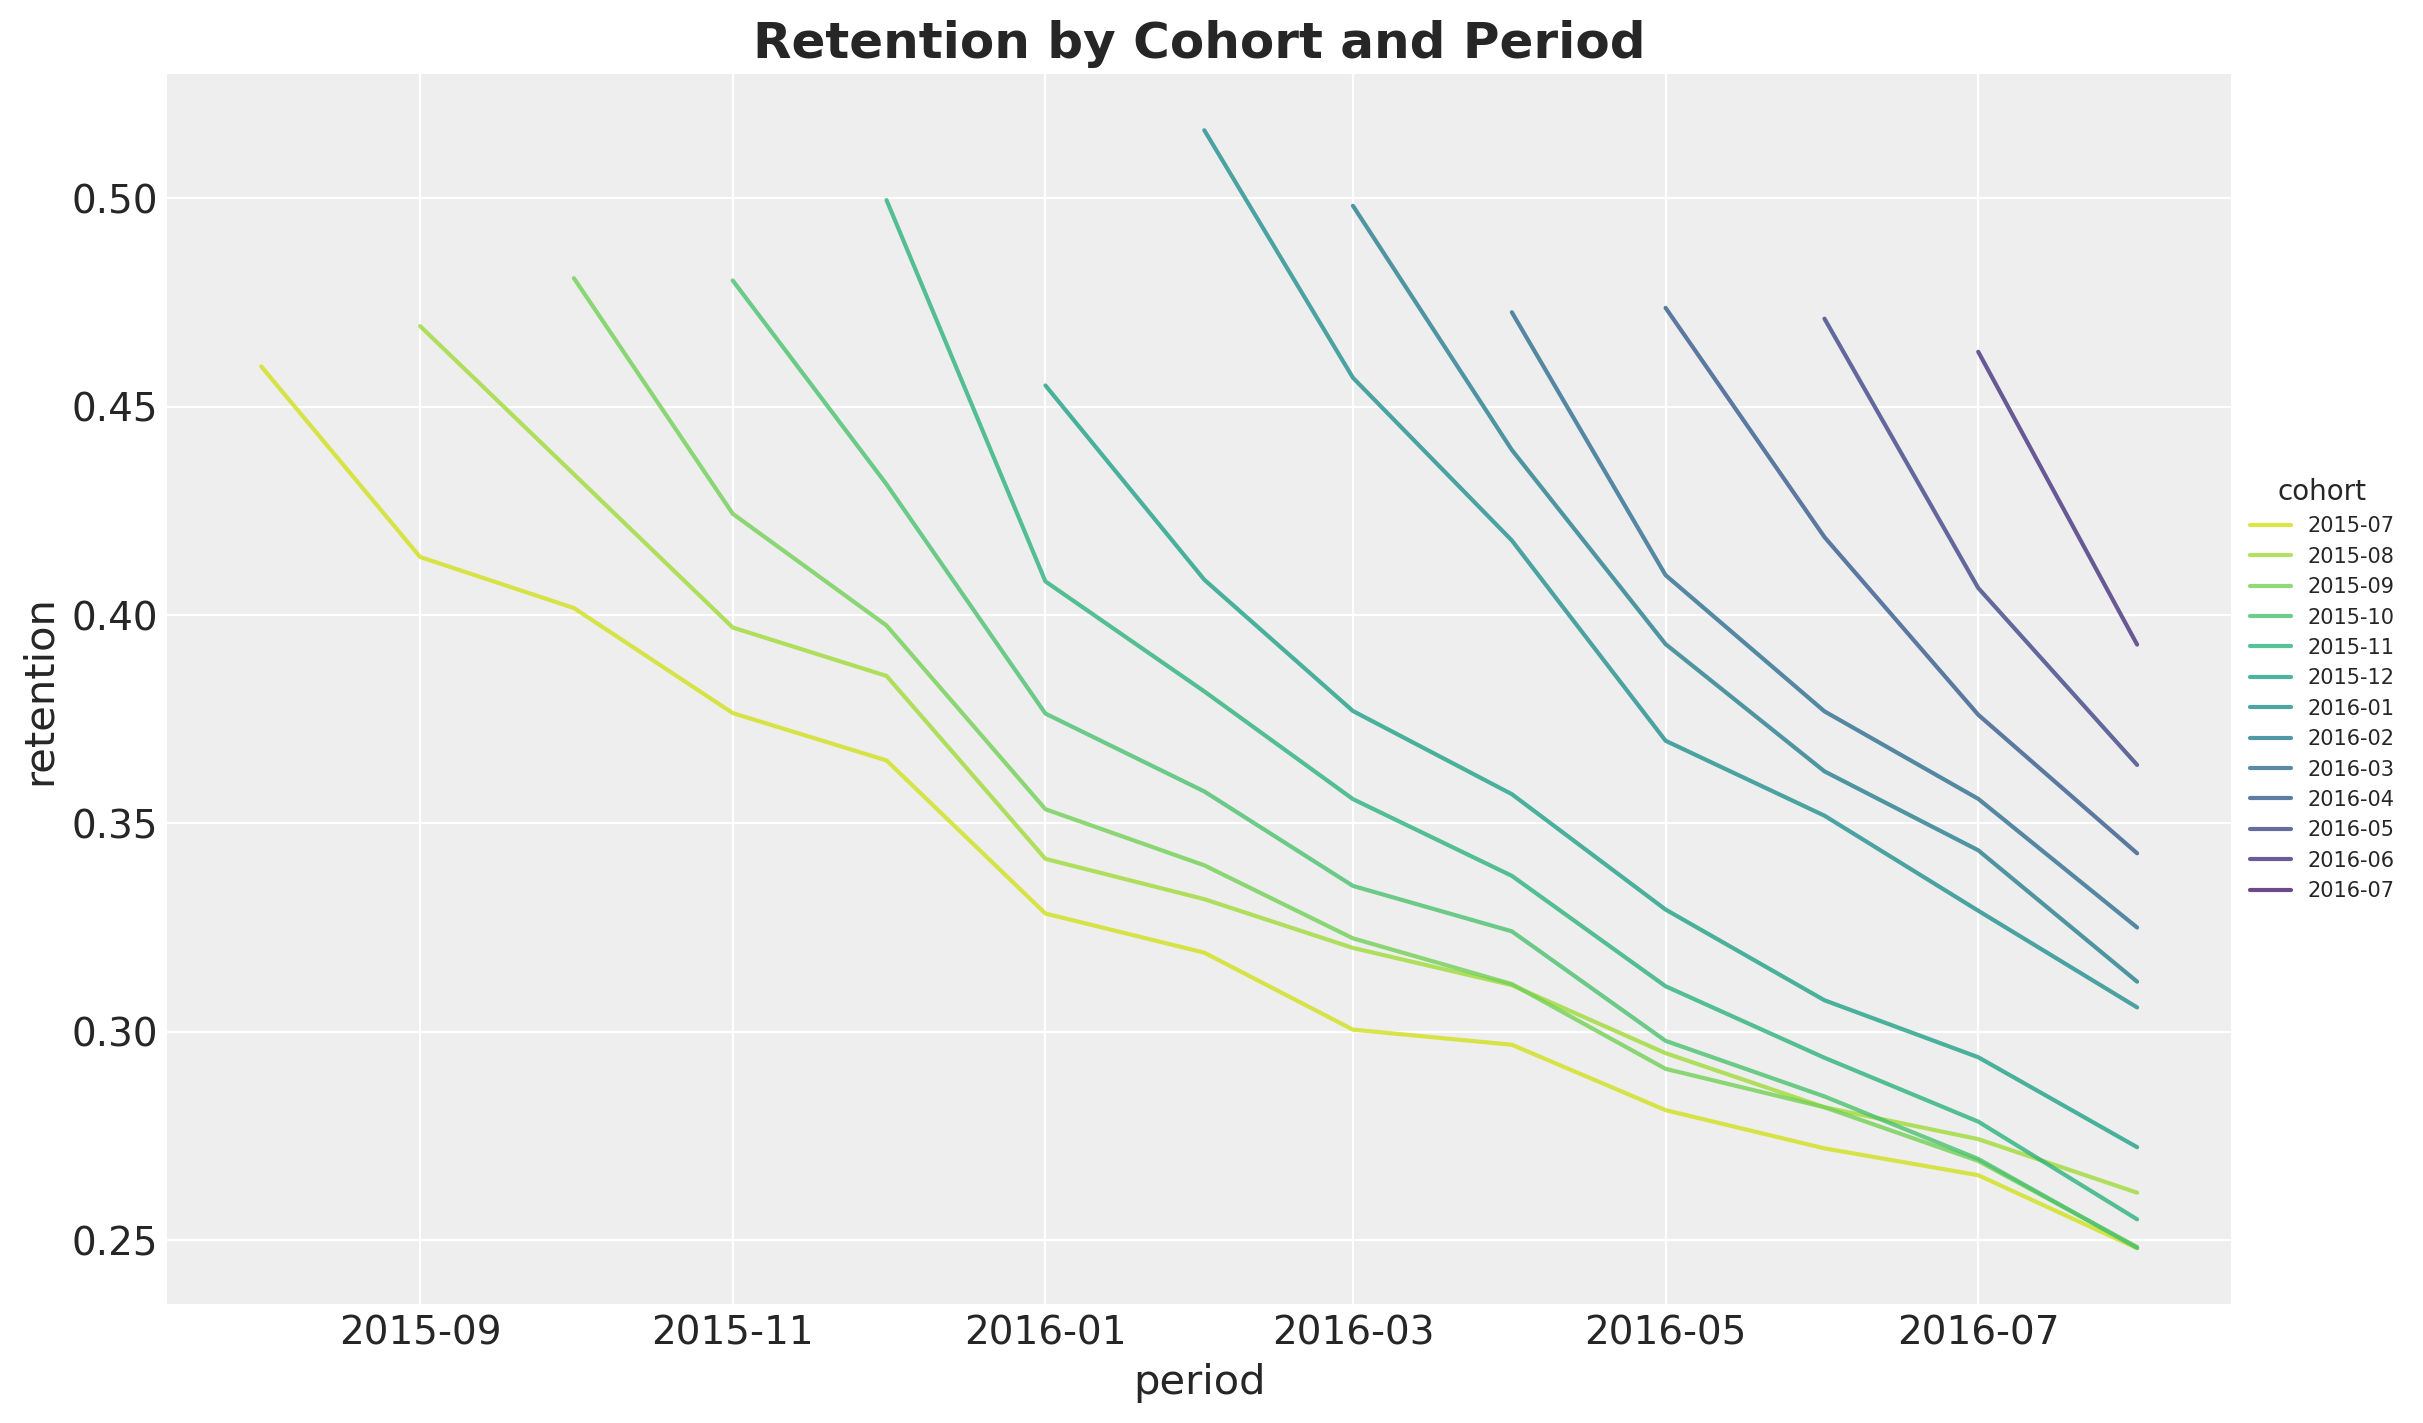

In [15]:
fig, ax = plt.subplots()
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.filter(pl.col("cohort_age").gt(pl.lit(0))).with_columns(
        pl.col("cohort").dt.strftime("%Y-%m").alias("cohort")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set_title("Retention by Cohort and Period", fontsize=18, fontweight="bold");

## Model

We use a retention-revenue model with the following structure:

\begin{align*}
\text{Revenue} & \sim \text{Gamma}(N_{\text{active}}, \lambda) \\
\log(\lambda) = (& \text{intercept} \\
    & + \beta_{\text{cohort age}} \text{cohort age} \\
    & + \beta_{\text{age}} \text{age} \\
    & + \beta_{\text{cohort age} \times \text{age}} \text{cohort age} \times \text{age} ) \\
N_{\text{active}} & \sim \text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) & = \text{BART}(\text{cohort age}, \text{age}, \text{month})
\end{align*}

### Data Transformations

We prepare the data for the PyMC model. This includes creating encoders, scalers, and
transforming features to the appropriate format.

In [16]:
eps = np.finfo(float).eps

# Filter for cohort_age > 0
train_data_red_df = train_data_df.filter(pl.col("cohort_age") > 0)

# Add month features for seasonality (all in polars, in a single call)
train_data_red_df = train_data_red_df.with_columns(
    [
        pl.col("cohort").dt.month().alias("cohort_month"),
        pl.col("period").dt.month().alias("period_month"),
    ]
)

train_obs_idx = range(train_data_red_df.height)

# Extract arrays using polars .to_numpy()
train_n_users = train_data_red_df.get_column("n_users").to_numpy()
train_n_active_users = train_data_red_df.get_column("n_active_users").to_numpy()
train_retention = train_data_red_df.get_column("retention").to_numpy()
train_retention_logit = logit(train_retention + eps)
train_revenue = train_data_red_df.get_column("revenue").to_numpy() + eps
train_cohort = train_data_red_df.get_column("cohort").to_numpy()
train_period = train_data_red_df.get_column("period").to_numpy()

# Encoders for cohort and period
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()
train_cohort_month_encoder = LabelEncoder()
train_cohort_month_idx = train_cohort_month_encoder.fit_transform(
    train_data_red_df.get_column("cohort_month")
).flatten()
train_period_month_encoder = LabelEncoder()
train_period_month_idx = train_period_month_encoder.fit_transform(
    train_data_red_df.get_column("period_month")
).flatten()

# Features for BART model, extract as polars DataFrame
features: list[str] = ["age", "cohort_age", "cohort_month", "period_month"]
x_train = train_data_red_df.select(
    ["age", "cohort_age", "cohort_month", "period_month"]
).to_numpy()

# Age and cohort_age arrays and scaling using numpy
train_age = train_data_red_df.get_column("age").to_numpy()
train_age_scaler = MaxAbsScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()

train_cohort_age = train_data_red_df.get_column("cohort_age").to_numpy()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

In [17]:
print(f"Number of observations: {len(train_obs_idx)}")
print(f"Number of unique cohorts: {len(train_cohort_encoder.classes_)}")
print(f"Number of unique periods: {len(train_period_encoder.classes_)}")

Number of observations: 91
Number of unique cohorts: 13
Number of unique periods: 13


### Model Specification

We specify the PyMC model with:
- A BART component for the retention rate (on the logit scale)
- A linear model for the revenue rate using a Gamma distribution
- The retention and revenue components are coupled through the estimated number of active users

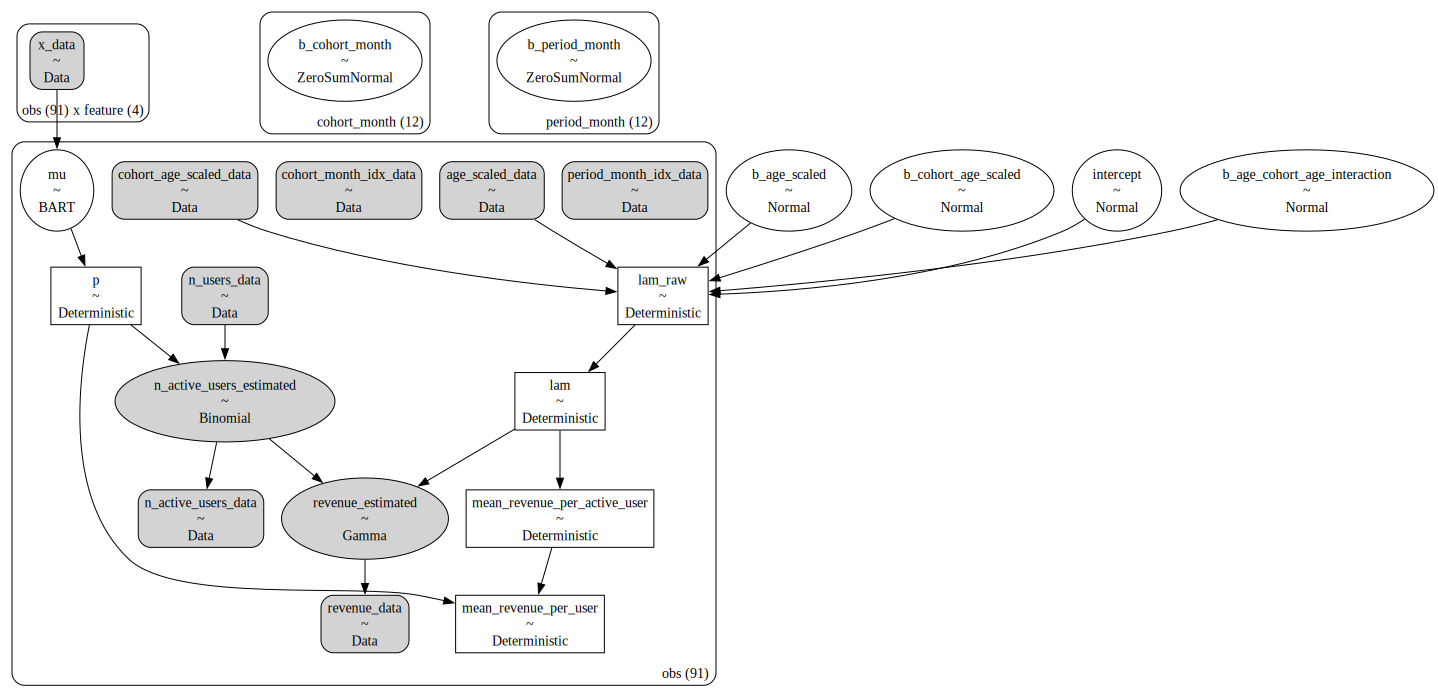

In [18]:
coords = {
    "feature": features,
    "obs": train_obs_idx,
    "cohort_month": train_cohort_month_encoder.classes_,
    "period_month": train_period_month_encoder.classes_,
}

with pm.Model(coords=coords) as model:
    # --- Data ---
    age_scaled_data = pm.Data(
        name="age_scaled_data", value=train_age_scaled, dims="obs"
    )
    cohort_age_scaled_data = pm.Data(
        name="cohort_age_scaled_data", value=train_cohort_age_scaled, dims="obs"
    )
    cohort_month_idx_data = pm.Data(
        name="cohort_month_idx_data", value=train_cohort_month_idx, dims="obs"
    )
    period_month_idx_data = pm.Data(
        name="period_month_idx_data", value=train_period_month_idx, dims="obs"
    )
    x_data = pm.Data(name="x_data", value=x_train, dims=("obs", "feature"))
    n_users_data = pm.Data(name="n_users_data", value=train_n_users, dims="obs")
    n_active_users_data = pm.Data(
        name="n_active_users_data", value=train_n_active_users, dims="obs"
    )
    revenue_data = pm.Data(name="revenue_data", value=train_revenue, dims="obs")

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=2)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=2)
    b_age_cohort_age_interaction = pm.Normal(
        name="b_age_cohort_age_interaction", mu=0, sigma=1
    )
    b_cohort_month = pm.ZeroSumNormal(
        name="b_cohort_month", sigma=3, dims="cohort_month"
    )
    b_period_month = pm.ZeroSumNormal(
        name="b_period_month", sigma=3, dims="period_month"
    )

    # --- Parametrization ---
    # The BART component models the image of the retention rate under the
    # logit transform so that the range is not constrained to [0, 1].
    mu = pmb.BART(
        name="mu",
        X=x_data,
        Y=train_retention_logit,
        m=200,
        response="mixed",
        split_rules=[
            ContinuousSplitRule(),
            ContinuousSplitRule(),
            SubsetSplitRule(),
            SubsetSplitRule(),
        ],
        dims="obs",
    )
    # We use the inverse logit transform to get the retention rate back into [0, 1].
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")
    # We add a small epsilon to avoid numerical issues.
    p = pt.switch(pt.eq(p, 0), eps, p)
    p = pt.switch(pt.eq(p, 1), 1 - eps, p)

    # For the revenue component we use a Gamma distribution where we combine the number
    # of estimated active users with the average revenue per user.
    lam_raw = pm.Deterministic(
        name="lam_raw",
        var=intercept
        + b_age_scaled * age_scaled_data
        + b_cohort_age_scaled * cohort_age_scaled_data
        + b_age_cohort_age_interaction * age_scaled_data * cohort_age_scaled_data,
        # + b_cohort_month[cohort_month_idx_data]
        # + b_period_month[period_month_idx_data],
        dims="obs",
    )

    lam = pm.Deterministic(name="lam", var=pt.softplus(lam_raw), dims="obs")

    # --- Likelihood ---
    n_active_users_estimated = pm.Binomial(
        name="n_active_users_estimated",
        n=n_users_data,
        p=p,
        observed=n_active_users_data,
        dims="obs",
    )

    revenue_estimated = pm.Gamma(
        name="revenue_estimated",
        alpha=n_active_users_estimated + eps,
        beta=lam,
        observed=revenue_data,
        dims="obs",
    )

    mean_revenue_per_active_user = pm.Deterministic(
        name="mean_revenue_per_active_user", var=(1 / lam), dims="obs"
    )
    pm.Deterministic(
        name="mean_revenue_per_user", var=p * mean_revenue_per_active_user, dims="obs"
    )

pm.model_to_graphviz(model=model)

### Model Fitting

Now we fit the model using MCMC sampling.

In [19]:
%%time

with model:
    idata = pm.sample(tune=1_500, draws=500, chains=14, cores=14, random_seed=rng)
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=rng))

Multiprocess sampling (14 chains in 14 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_cohort_month, b_period_month]
>PGBART: [mu]


Output()

Sampling 14 chains for 1_500 tune and 500 draw iterations (21_000 + 7_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

CPU times: user 17.9 s, sys: 1.85 s, total: 19.7 s
Wall time: 1min 55s


## Model Diagnostics

We examine the posterior predictive checks and trace plots to ensure the model has converged properly.

### Posterior Predictive Check

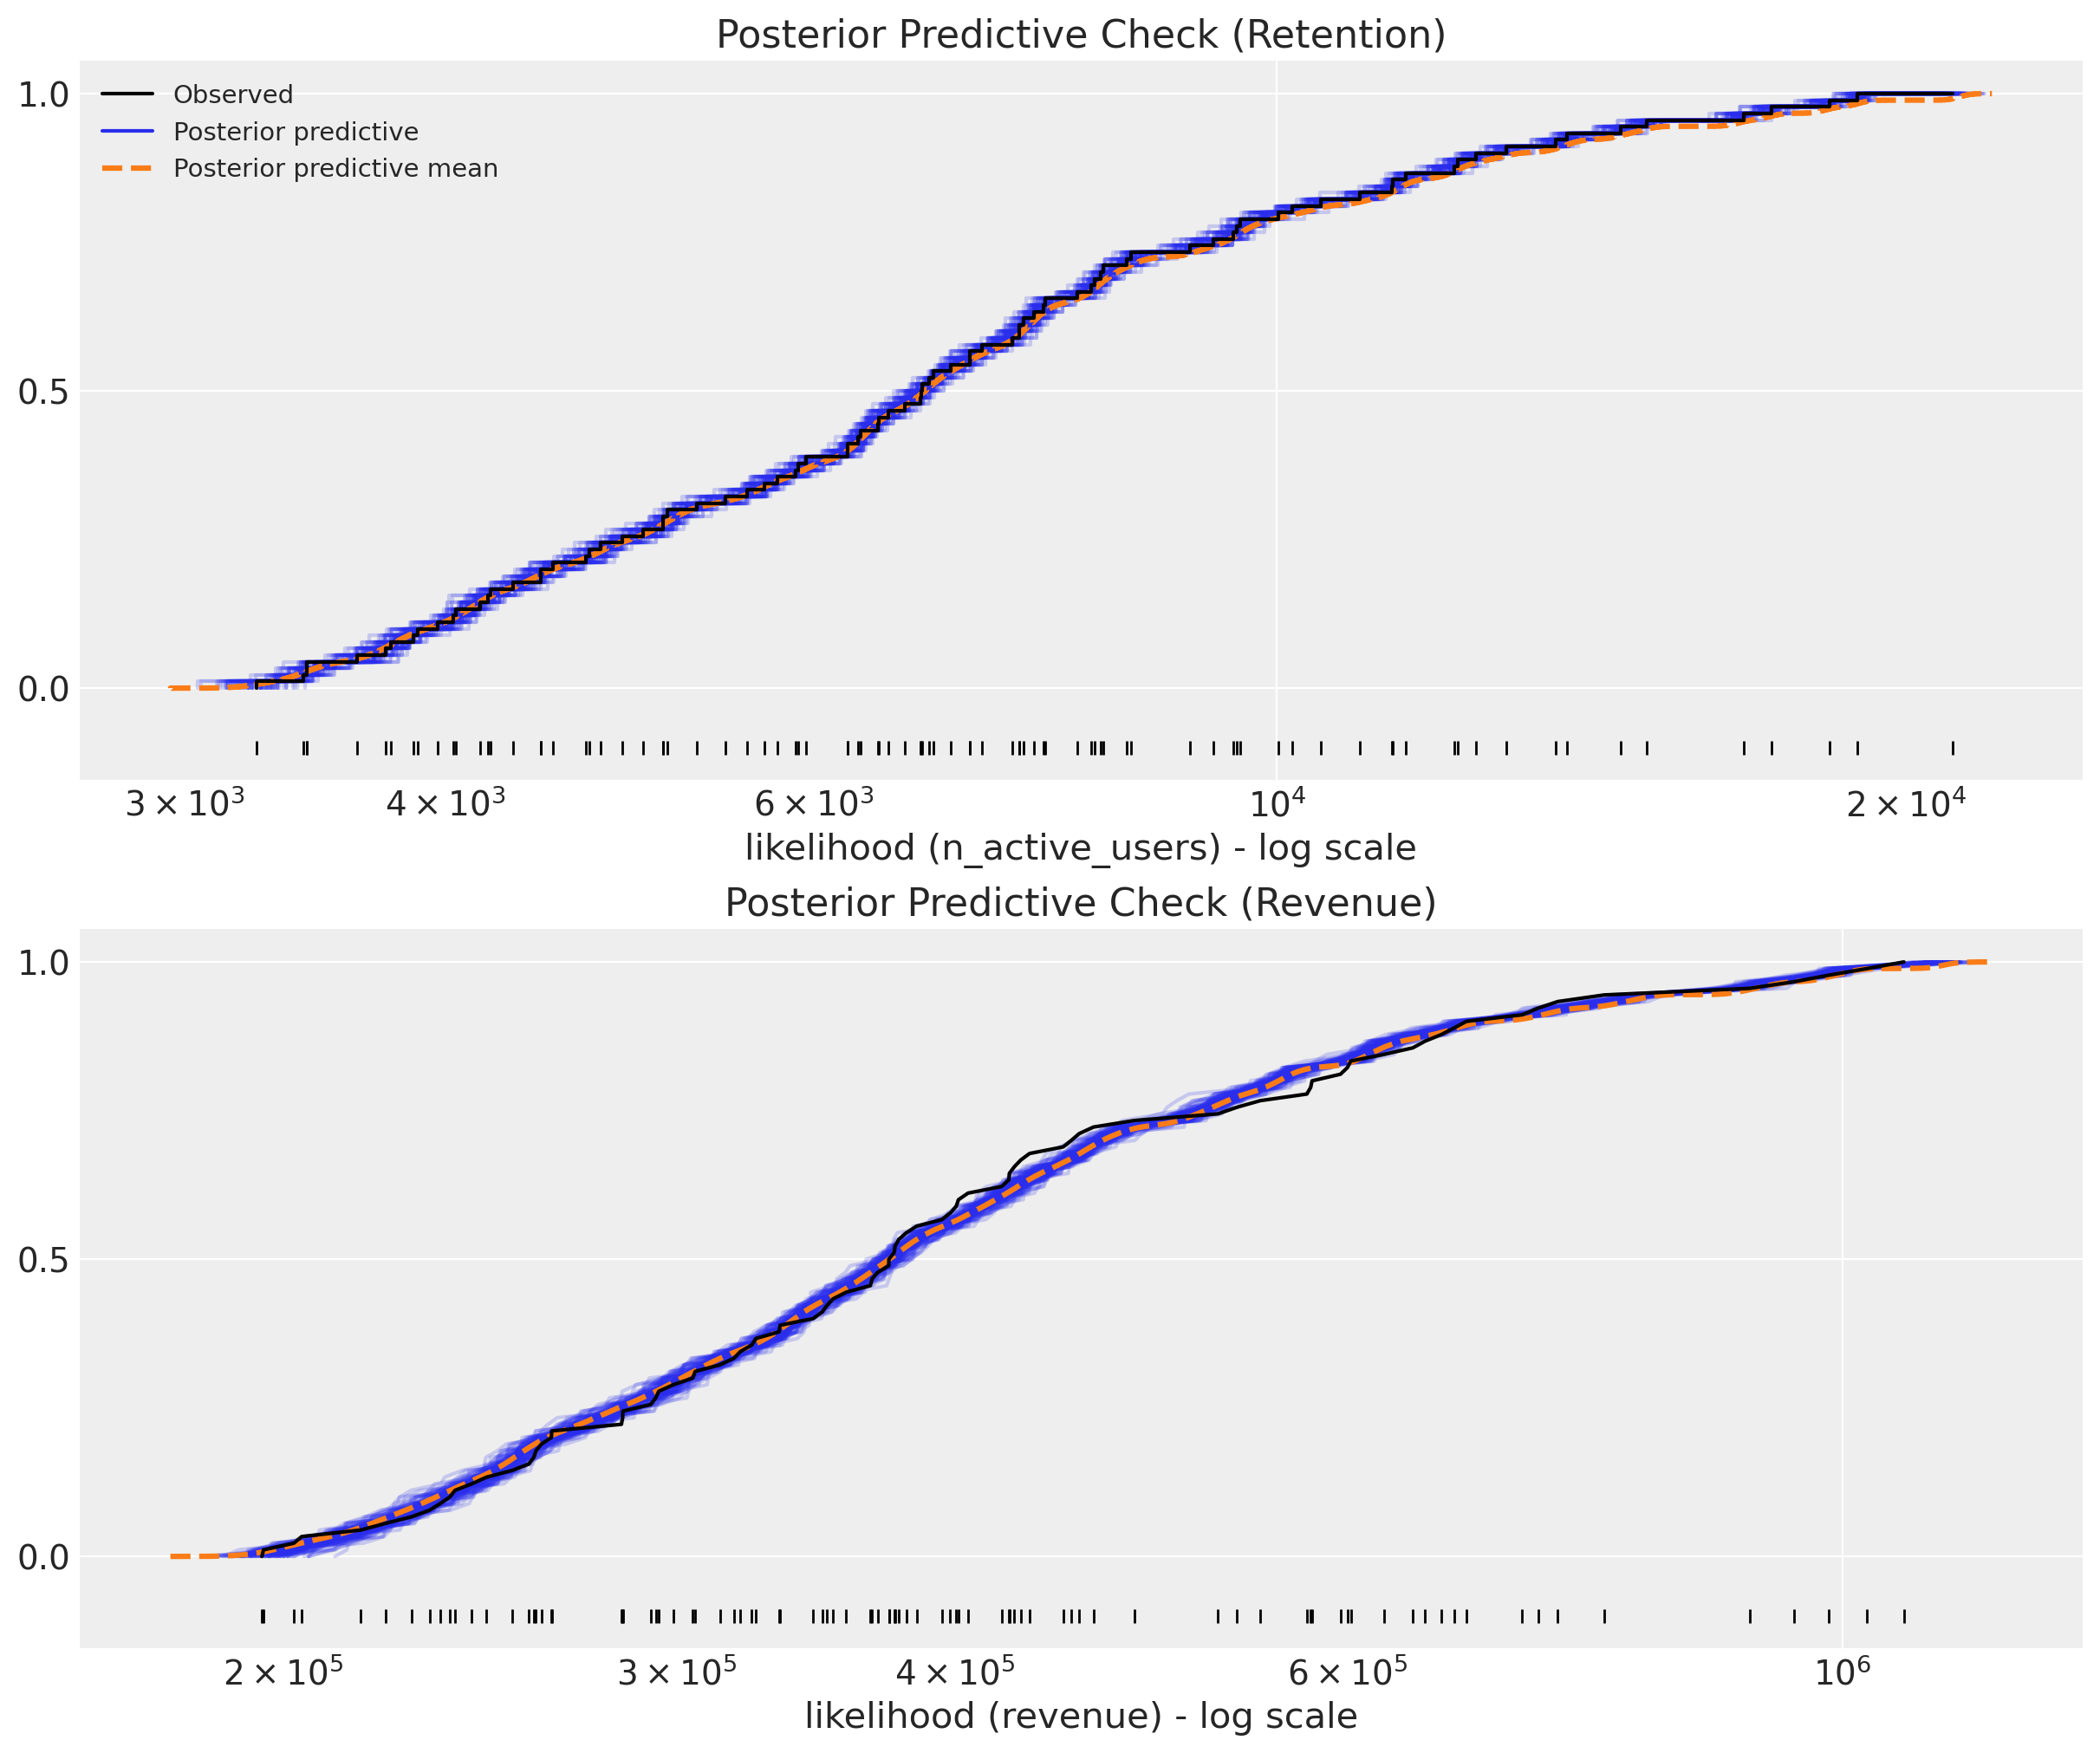

In [20]:
ax = az.plot_ppc(
    data=idata,
    kind="cumulative",
    num_pp_samples=100,
    observed_rug=True,
    grid=(2, 1),
    figsize=(12, 10),
    random_seed=seed,
)
ax[0].set(
    title="Posterior Predictive Check (Retention)",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
)
ax[1].set(
    title="Posterior Predictive Check (Revenue)",
    xscale="log",
    xlabel="likelihood (revenue) - log scale",
);

### Check for Divergences

In [21]:
n_divergences = idata.sample_stats["diverging"].sum().item()
print(f"Number of divergences: {n_divergences}")
assert n_divergences == 0, f"Model has {n_divergences} divergences!"

Number of divergences: 0


### Trace Plots for Revenue Parameters

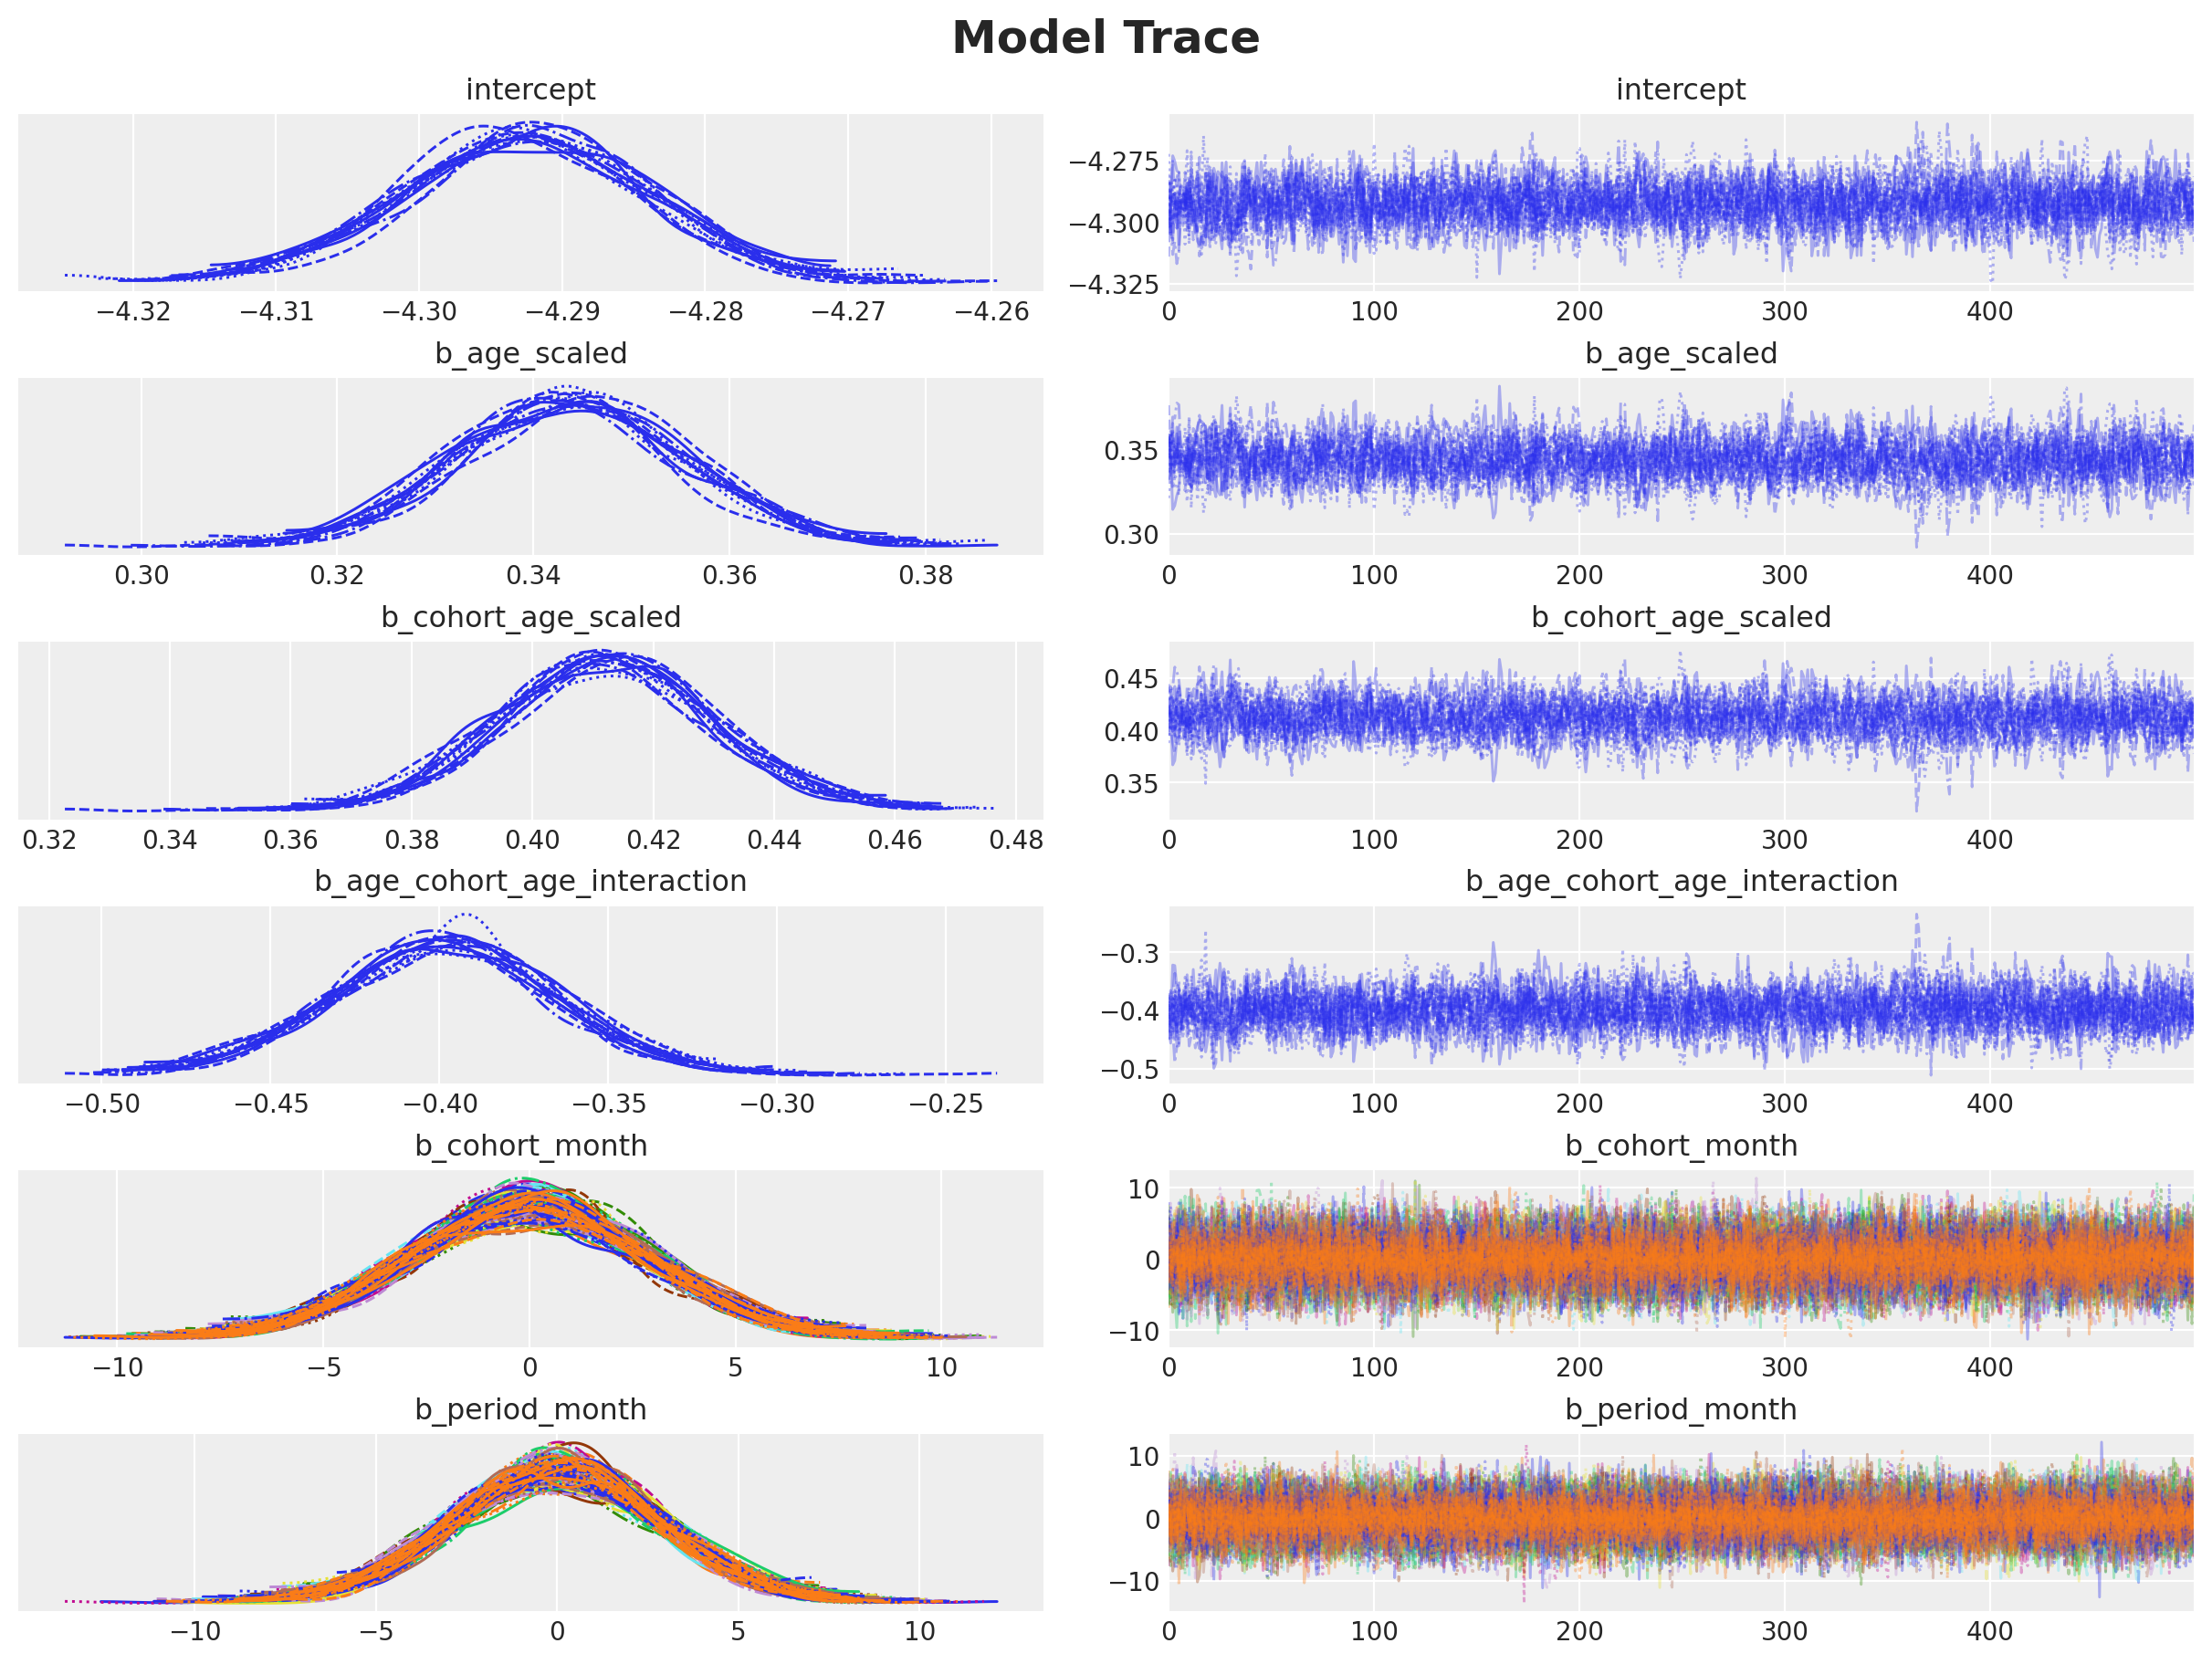

In [22]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "intercept",
        "b_age_scaled",
        "b_cohort_age_scaled",
        "b_age_cohort_age_interaction",
        "b_cohort_month",
        "b_period_month",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

## In-Sample Predictions

We examine how well the model fits the training data by comparing the posterior means
with the observed values.

### Retention

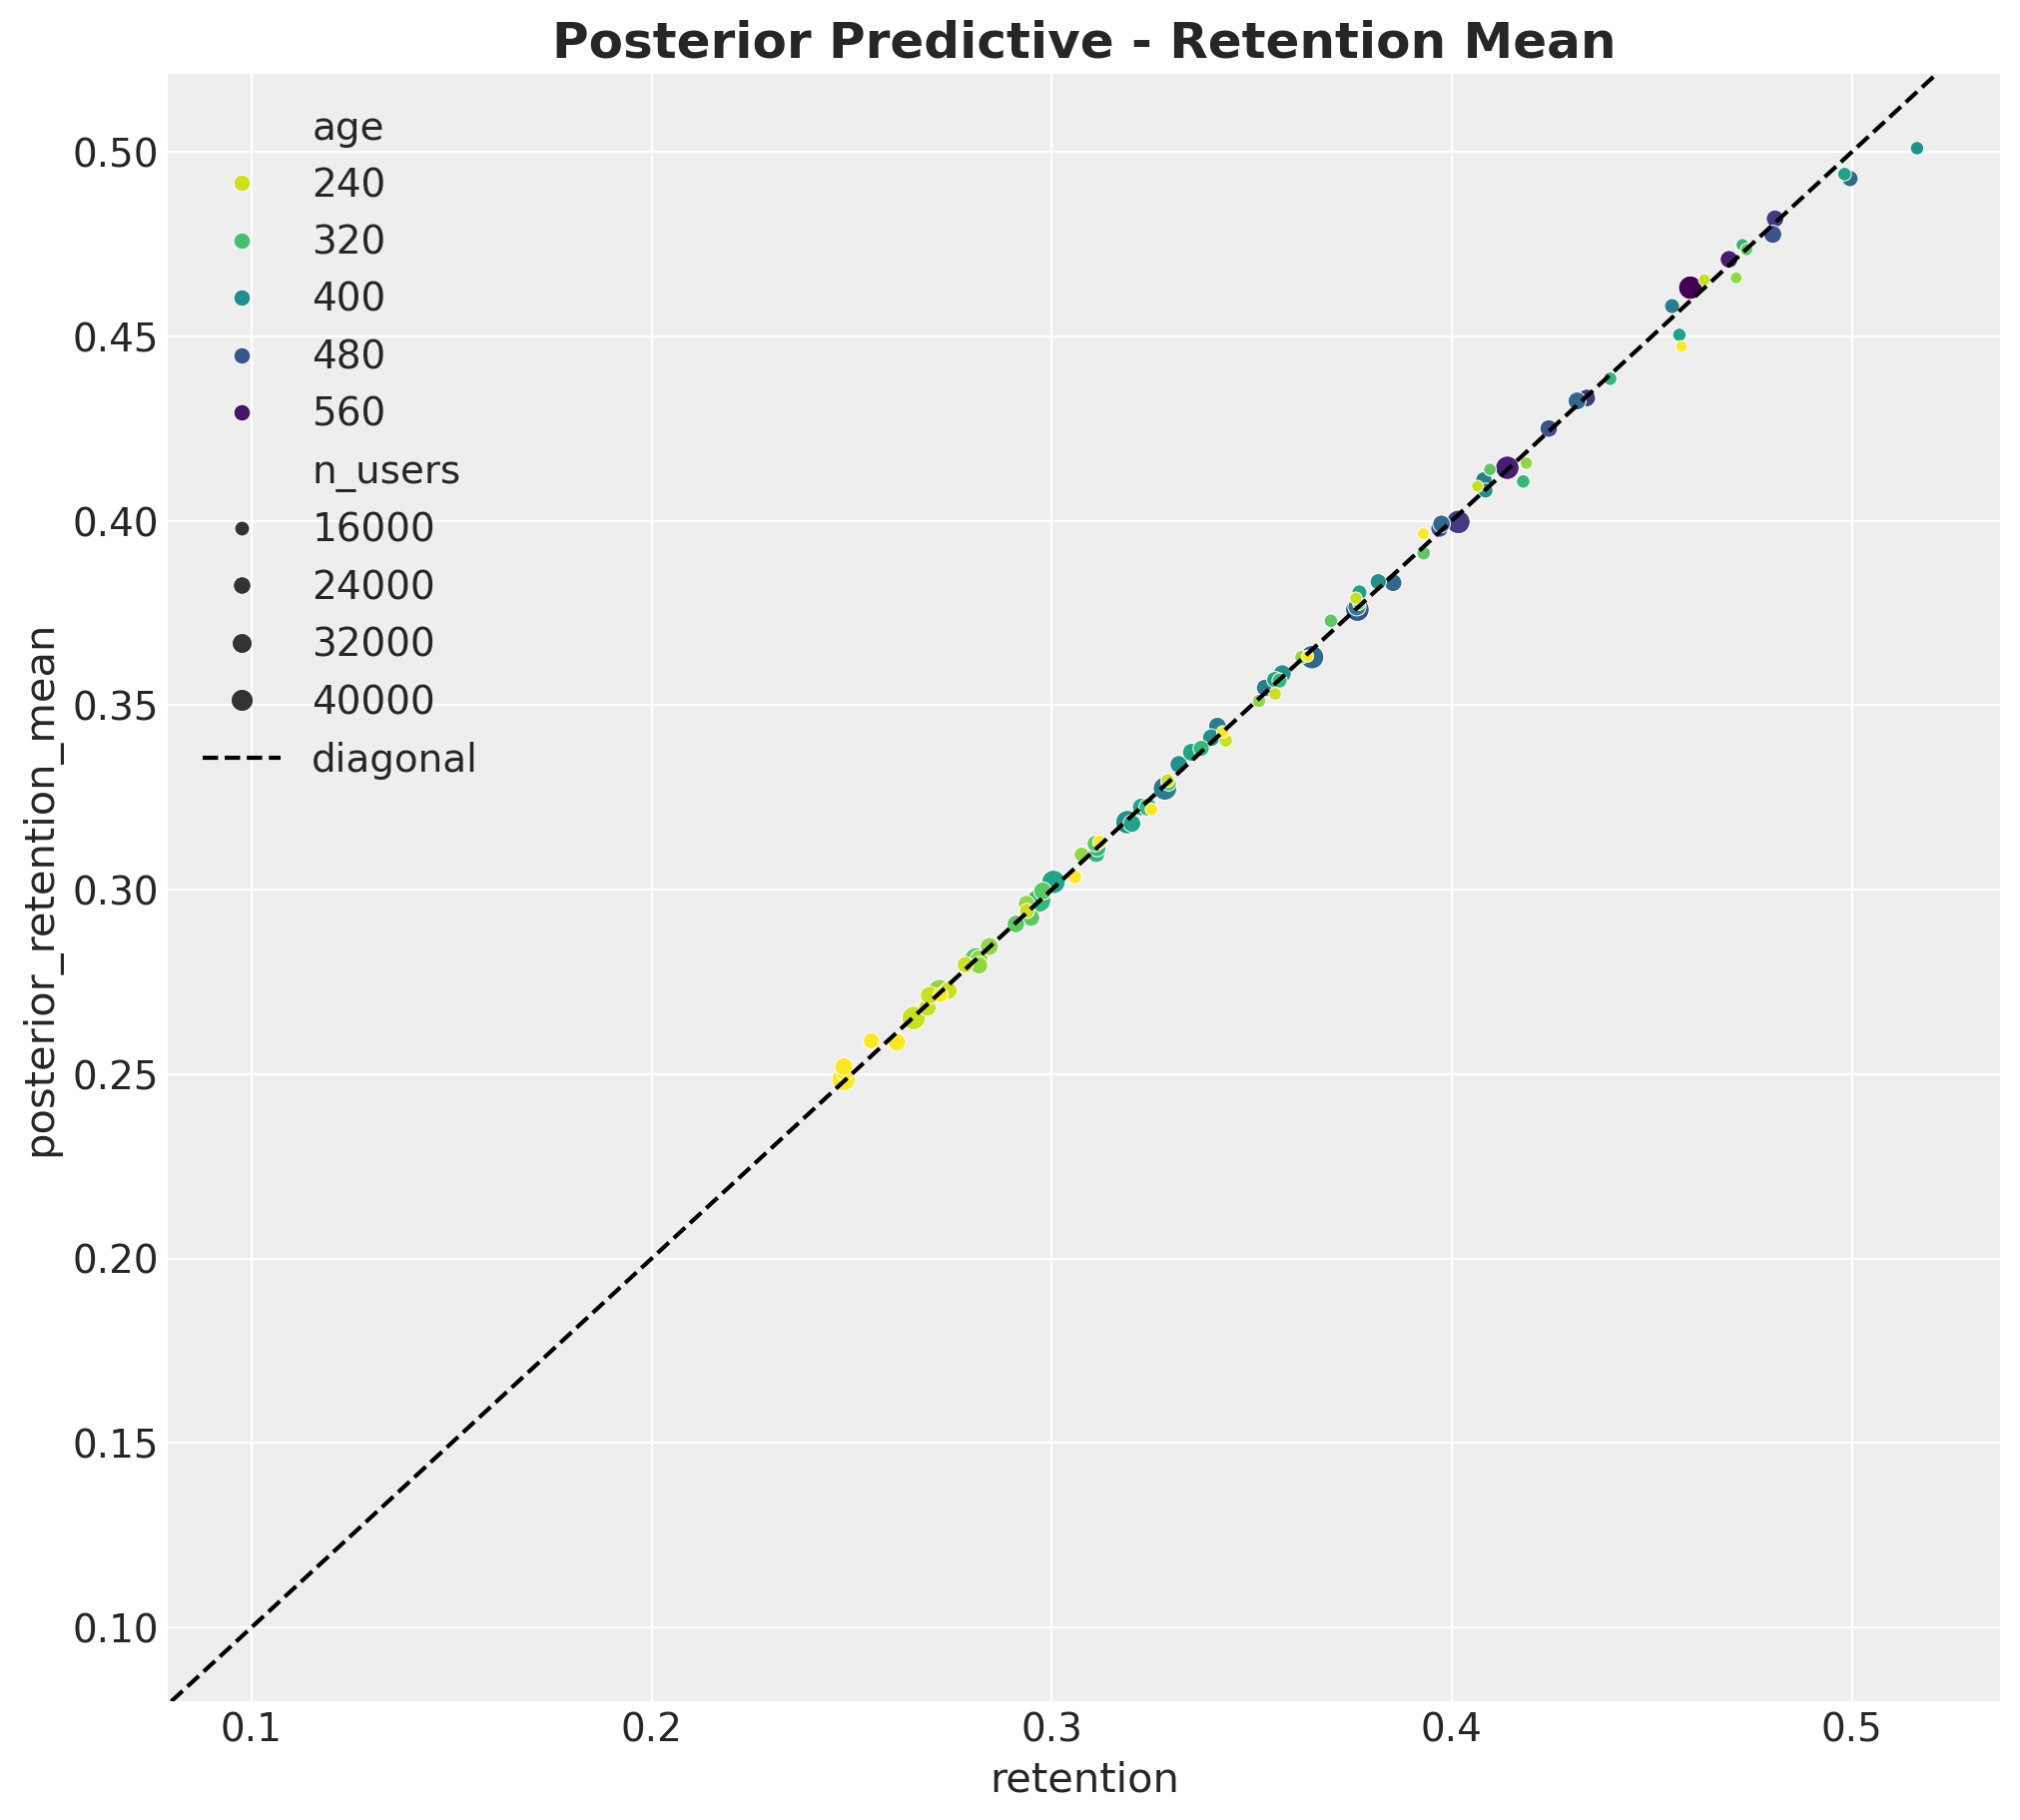

In [23]:
train_posterior_retention = (
    idata["posterior_predictive"]["n_active_users_estimated"]
    / train_n_users[np.newaxis, None]
)
train_posterior_retention_mean = az.extract(
    data=train_posterior_retention, var_names=["n_active_users_estimated"]
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=train_data_red_df.to_pandas().assign(
        posterior_retention_mean=train_posterior_retention_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0.1, 0.1), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set_title("Posterior Predictive - Retention Mean", fontsize=18, fontweight="bold");

### Revenue

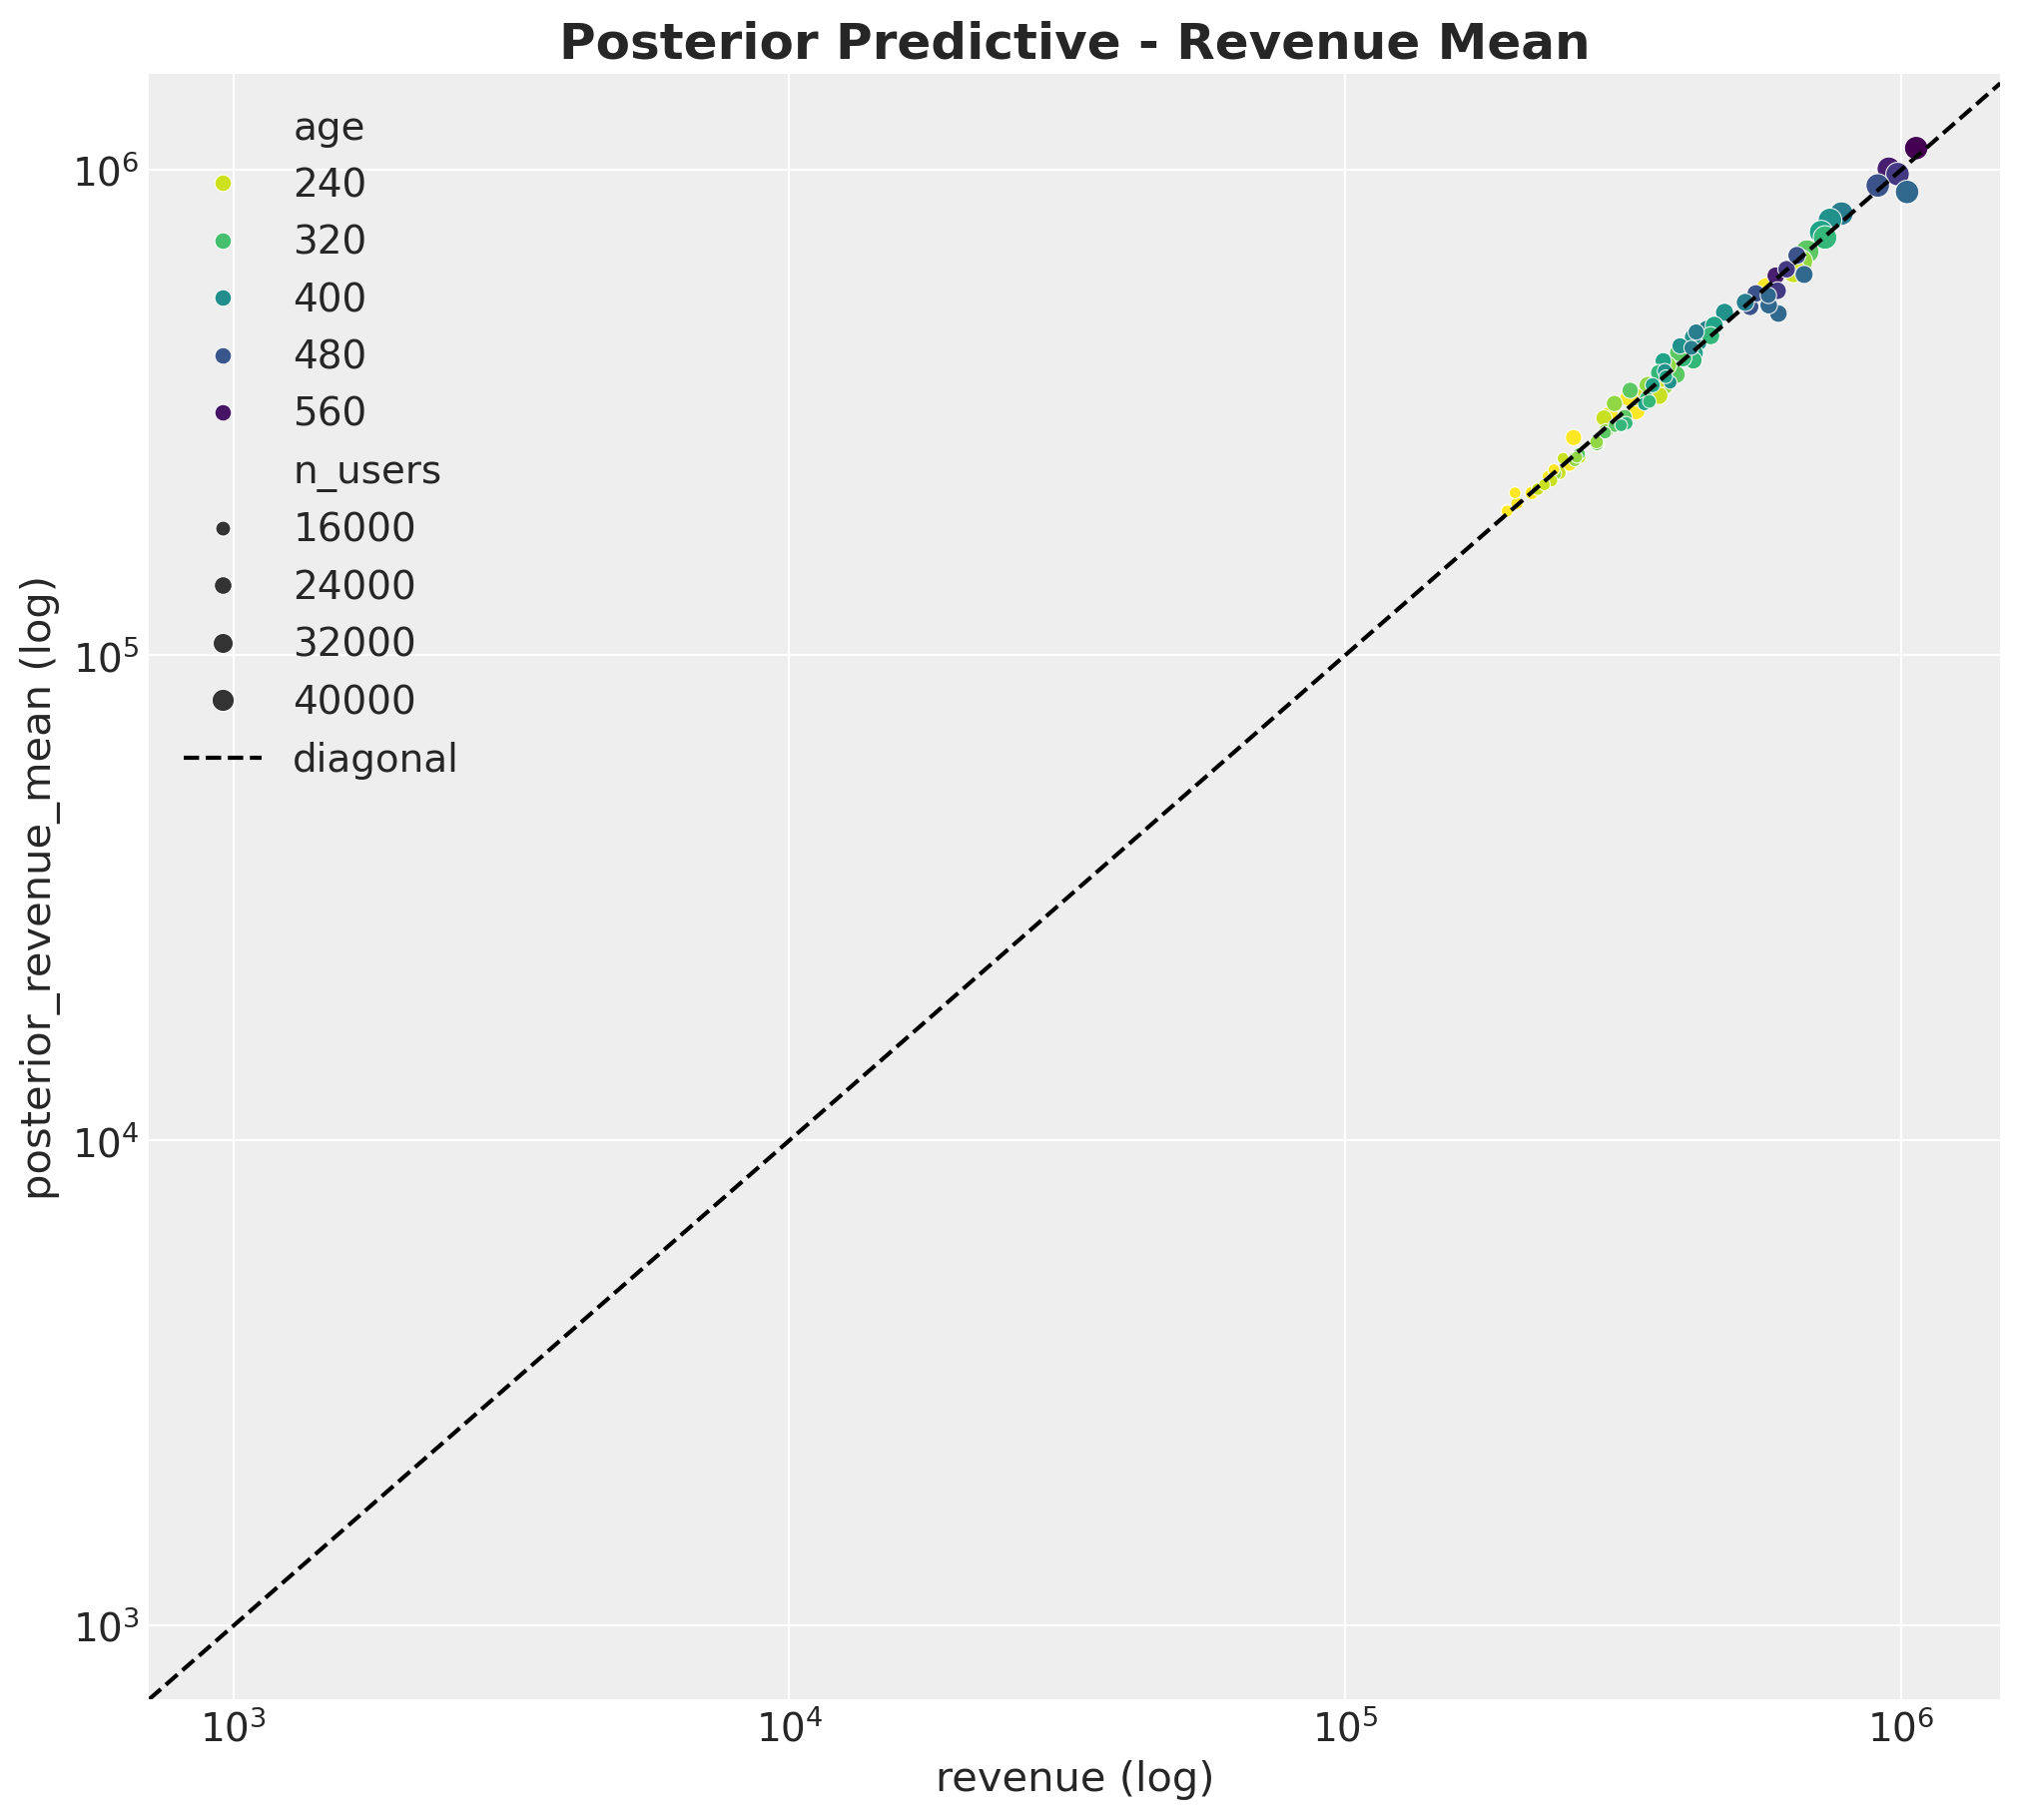

In [24]:
train_posterior_revenue_mean = az.extract(
    data=idata["posterior_predictive"],
    group="posterior_predictive",
    var_names=["revenue_estimated"],
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="revenue",
    y="posterior_revenue_mean",
    data=train_data_red_df.to_pandas().assign(
        posterior_revenue_mean=train_posterior_revenue_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(1e3, 1e3), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="revenue (log)",
    ylabel="posterior_revenue_mean (log)",
)
ax.set_title("Posterior Predictive - Revenue Mean", fontsize=18, fontweight="bold");

### In-Sample HDI Plots by Cohort

We plot the HDI (Highest Density Interval) for a subset of cohorts to visualize
the uncertainty in the predictions.

#### Retention HDI

In [25]:
train_retention_hdi = az.hdi(ary=train_posterior_retention)["n_active_users_estimated"]


def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_retention_hdi[mask, :][:, 0],
        y2=train_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed retention (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Retention HDI - Cohort {cohort_name}")
    return ax

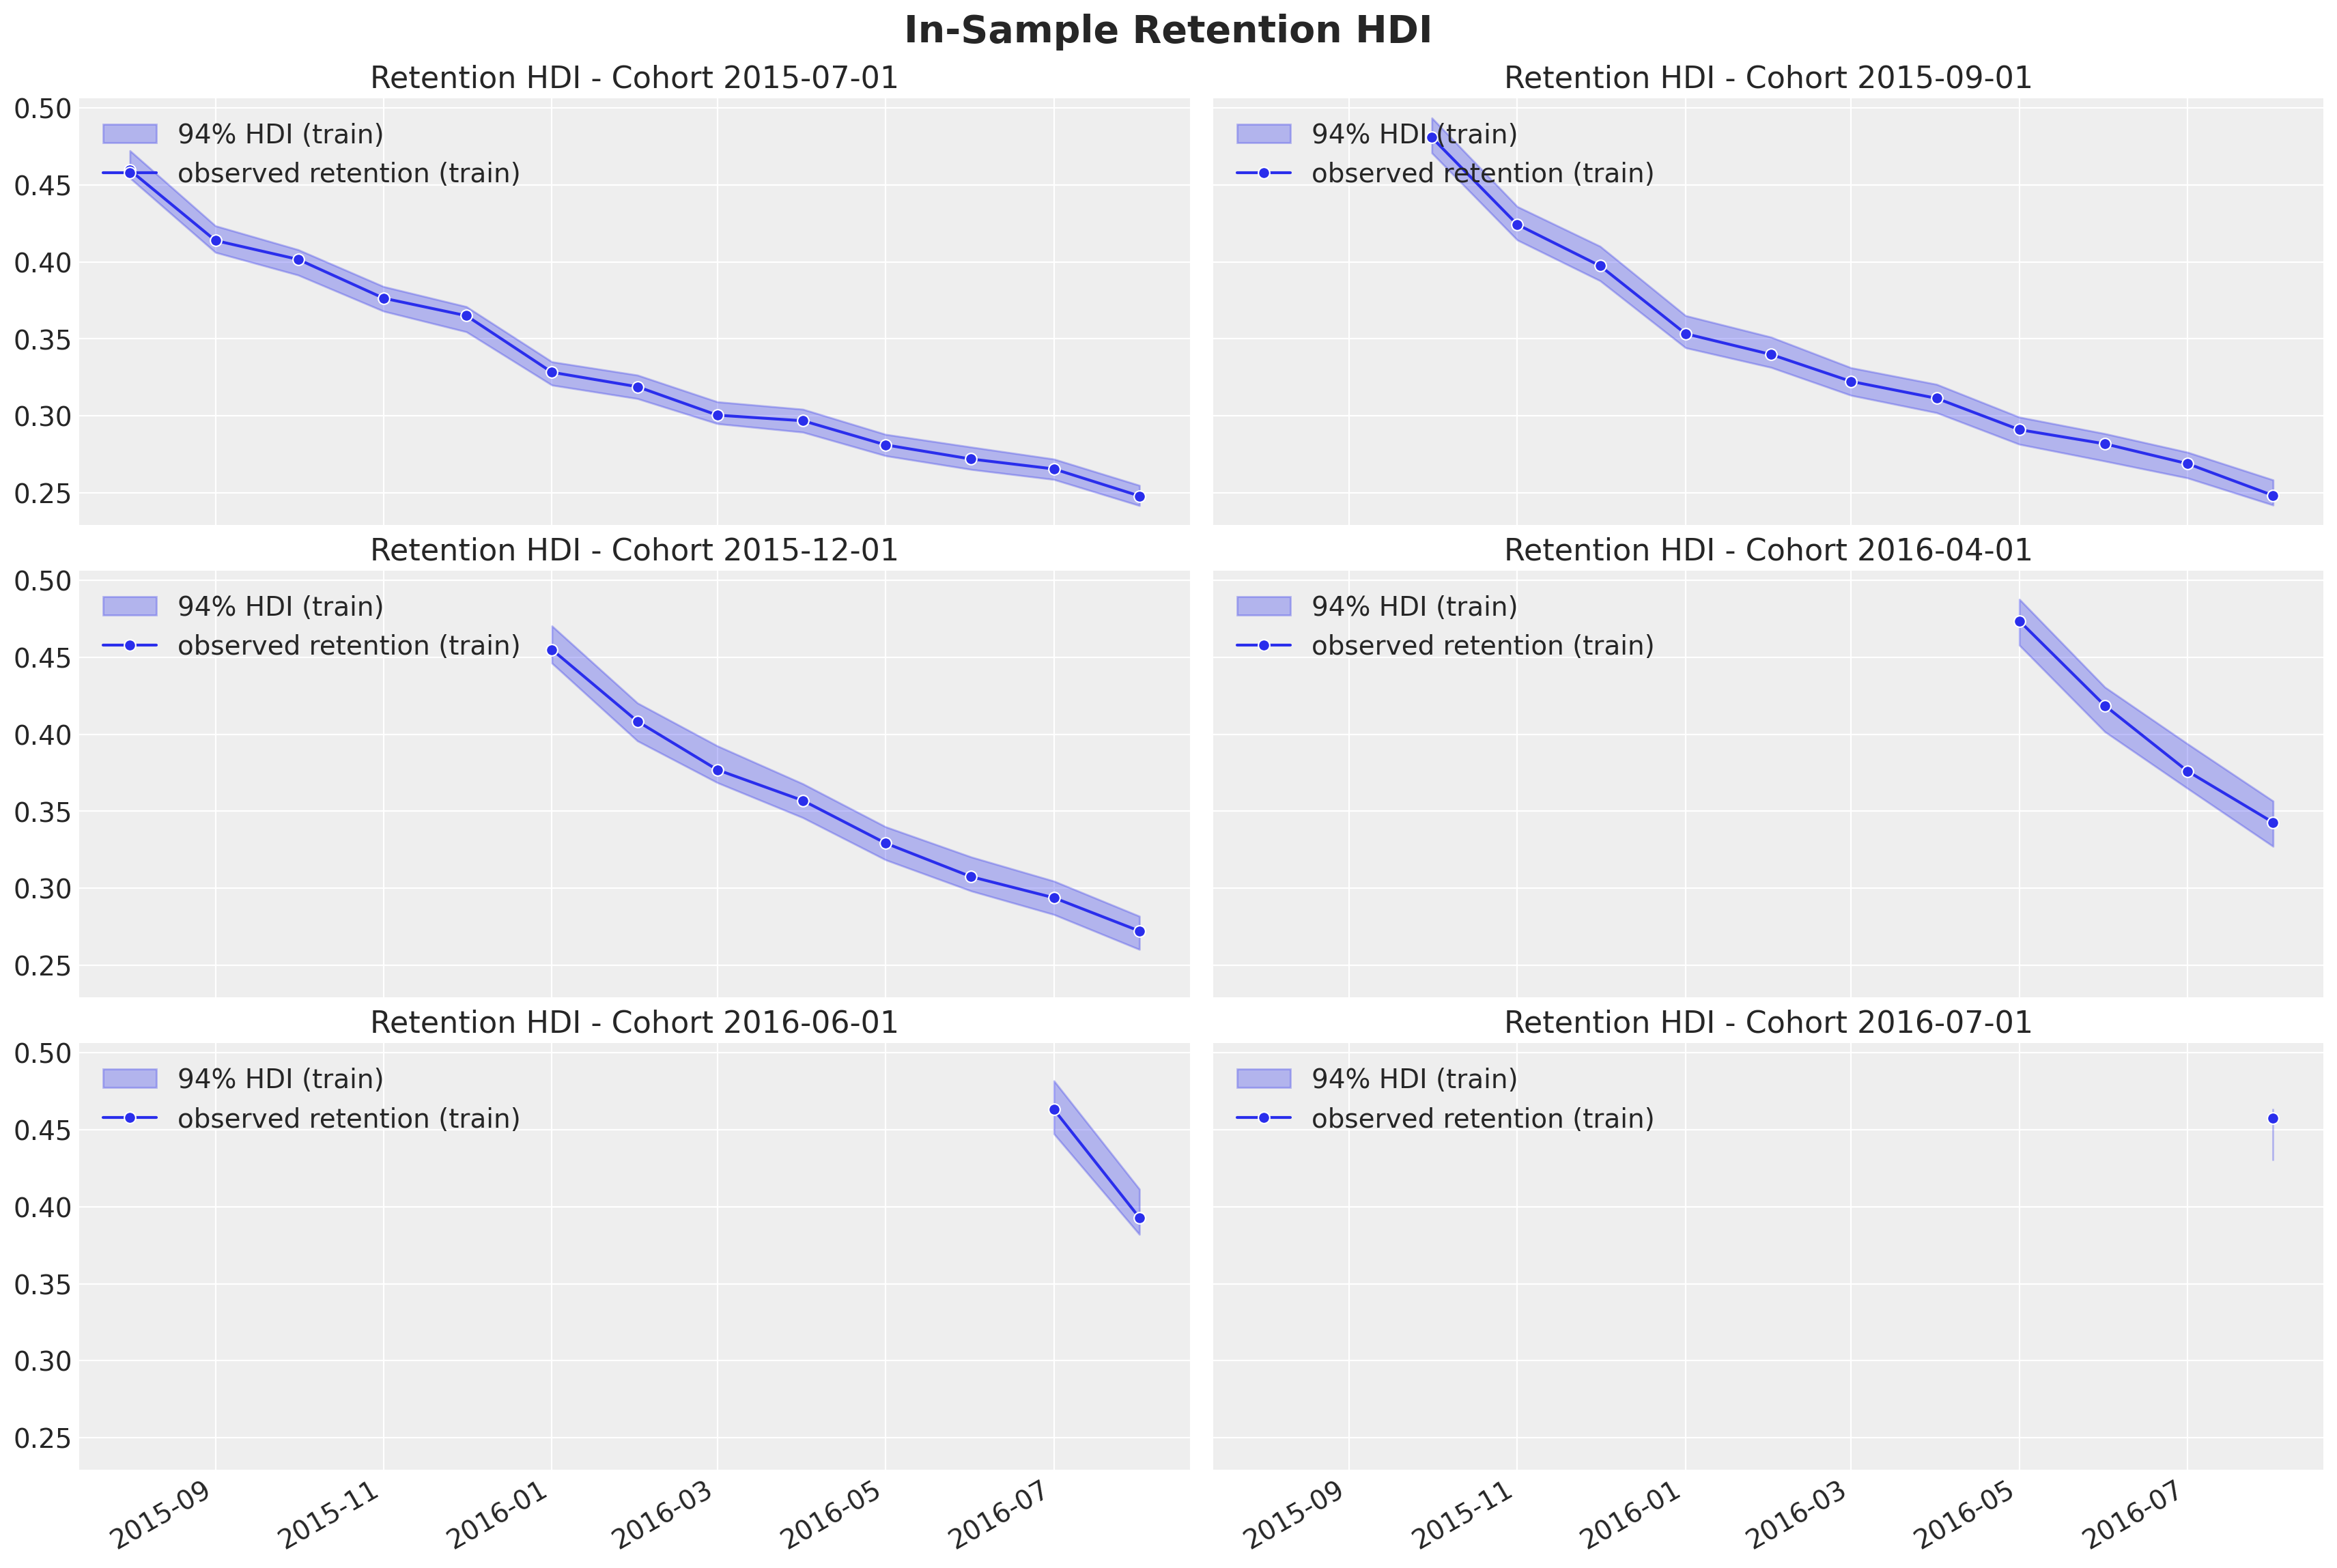

In [29]:
# Select cohorts to plot (adjust indices based on available cohorts)
n_cohorts = len(train_cohort_encoder.classes_)
cohort_index_to_plot = [0, 2, 5, 9, 11, 12]
cohort_index_to_plot = [i for i in cohort_index_to_plot if i < n_cohorts]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Retention HDI", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

#### Revenue HDI

In [30]:
train_revenue_hdi = az.hdi(ary=idata["posterior_predictive"])["revenue_estimated"]


def plot_train_revenue_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_revenue_hdi[mask, :][:, 0],
        y2=train_revenue_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_revenue[mask],
        color="C0",
        marker="o",
        label="observed revenue (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Revenue HDI - Cohort {cohort_name}")
    return ax

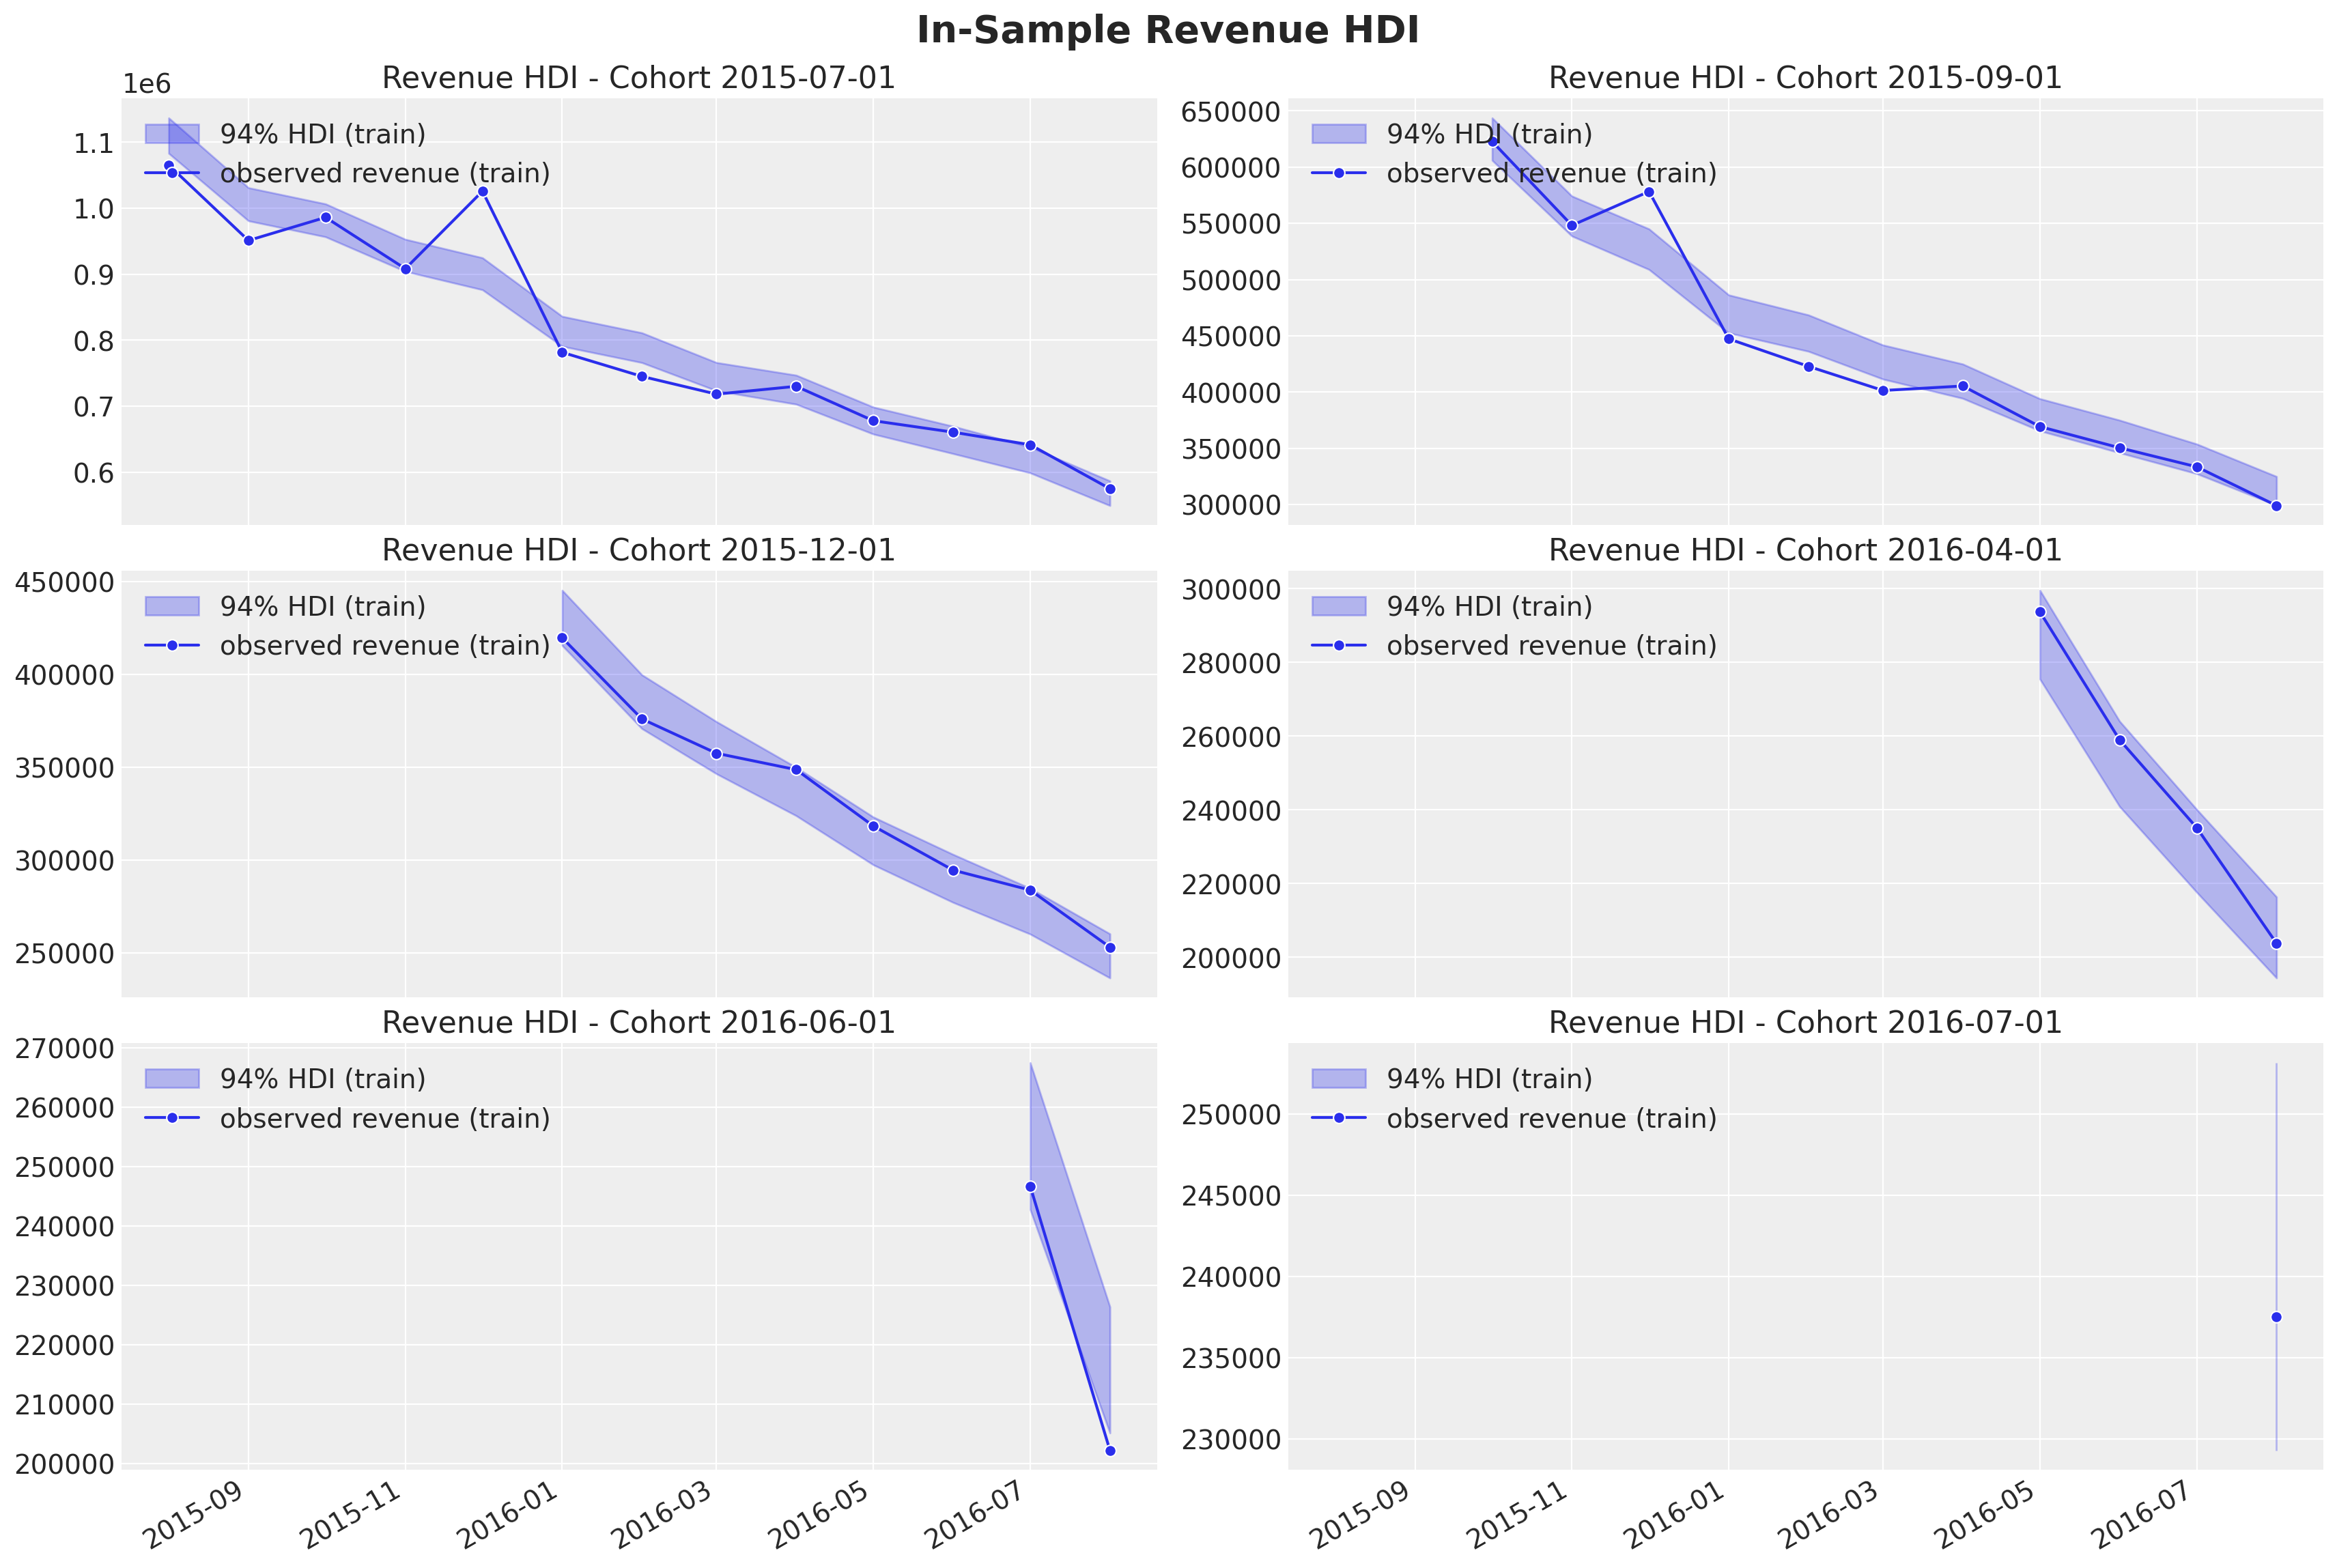

In [31]:
fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Revenue HDI", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

## Revenue per User Analysis

We analyze the posterior means for revenue per user and revenue per active user
to understand how these metrics vary with cohort age.

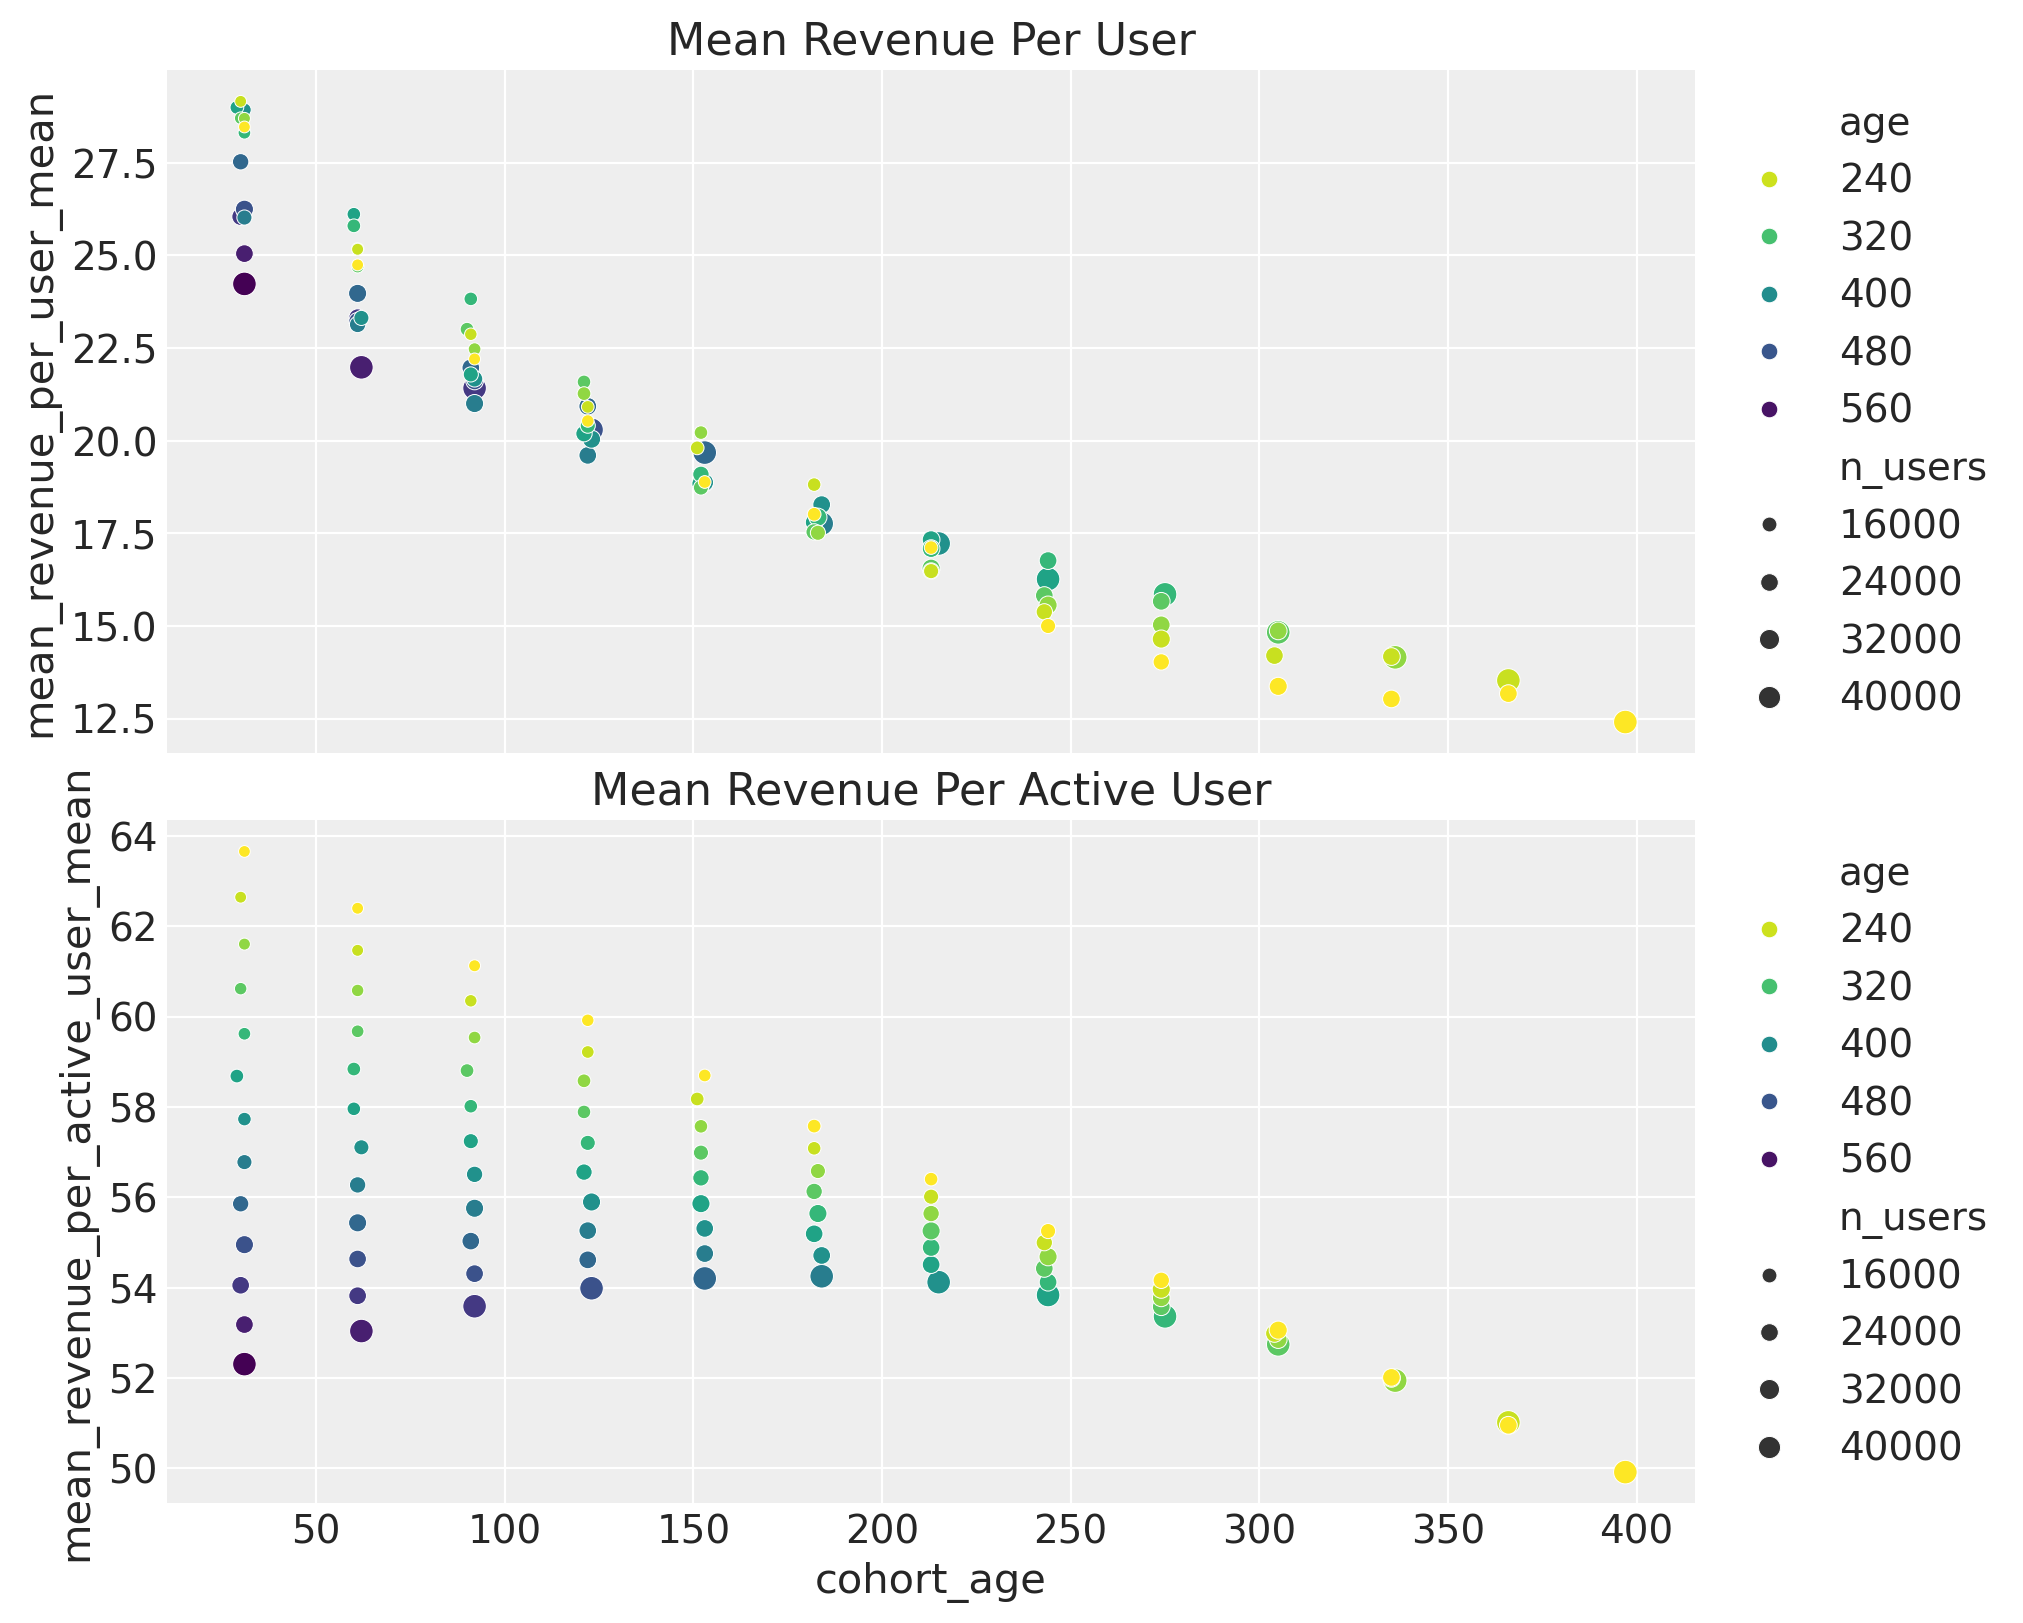

In [32]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True,
    sharey=False,
    layout="constrained",
)

(
    train_data_red_df.to_pandas()
    .assign(
        mean_revenue_per_user_mean=idata["posterior"]["mean_revenue_per_user"].mean(
            dim=["chain", "draw"]
        ),
    )
    .pipe(
        (sns.scatterplot, "data"),
        x="cohort_age",
        y="mean_revenue_per_user_mean",
        hue="age",
        palette="viridis_r",
        size="n_users",
        ax=ax[0],
    )
)
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set(title="Mean Revenue Per User")

(
    train_data_red_df.to_pandas()
    .assign(
        mean_revenue_per_active_user_mean=idata["posterior"][
            "mean_revenue_per_active_user"
        ].mean(dim=["chain", "draw"]),
    )
    .pipe(
        (sns.scatterplot, "data"),
        x="cohort_age",
        y="mean_revenue_per_active_user_mean",
        hue="age",
        palette="viridis_r",
        size="n_users",
        ax=ax[1],
    )
)
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set(title="Mean Revenue Per Active User");

## Out-of-Sample Predictions

We now make predictions on the test set to evaluate the model's generalization performance.

### Test Data Transformations

We transform the test data using the same scalers and encoders fitted on the training data.

In [33]:
test_data_red_df = test_data_df.filter(pl.col("cohort_age").gt(pl.lit(0)))
test_data_red_df = test_data_red_df.filter(
    pl.col("cohort").is_in(train_data_red_df["cohort"].unique().to_list())
)

test_data_red_df = test_data_red_df.with_columns(
    [
        pl.col("cohort").dt.month().alias("cohort_month"),
        pl.col("period").dt.month().alias("period_month"),
    ]
)

test_obs_idx = range(
    train_data_red_df.height, train_data_red_df.height + test_data_red_df.height
)
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()
test_revenue = test_data_red_df["revenue"].to_numpy()

test_period = test_data_red_df["period"].to_numpy()

test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()

test_cohort_month = test_data_red_df["cohort_month"].to_numpy()
test_cohort_month_idx = train_cohort_month_encoder.transform(
    test_cohort_month
).flatten()

test_period_month = test_data_red_df["period_month"].to_numpy()
test_period_month_idx = train_period_month_encoder.transform(
    test_period_month
).flatten()

x_test = test_data_red_df[features].to_numpy()

test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(
    test_cohort_age.reshape(-1, 1)
).flatten()

In [34]:
print(f"Test observations: {len(test_obs_idx)}")

Test observations: 39


### Out-of-Sample Posterior Predictions

We calculate the posterior predictive distribution for the test data.

In [35]:
%%time

with model:
    pm.set_data(
        new_data={
            "age_scaled_data": test_age_scaled,
            "cohort_age_scaled_data": test_cohort_age_scaled,
            "x_data": x_test,
            "cohort_month_idx_data": test_cohort_month_idx,
            "period_month_idx_data": test_period_month_idx,
            "n_users_data": test_n_users,
            "n_active_users_data": np.ones_like(
                test_n_active_users
            ),  # Dummy data for coords
            "revenue_data": np.ones_like(test_revenue),  # Dummy data for coords
        },
        coords={"obs": test_obs_idx},
    )
    idata_oos = pm.sample_posterior_predictive(
        trace=idata,
        var_names=[
            "p",
            "mu",
            "n_active_users_estimated",
            "revenue_estimated",
            "mean_revenue_per_user",
            "mean_revenue_per_active_user",
        ],
        idata_kwargs={"coords": {"obs": test_obs_idx}},
        random_seed=rng,
    )

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

CPU times: user 1min 52s, sys: 12.2 s, total: 2min 4s
Wall time: 4min 14s


### Retention and Revenue Out-of-Sample Predictions

We plot the posterior predictive distribution for the retention and revenue components
comparing training and test data.

In [36]:
test_posterior_retention = (
    idata_oos["posterior_predictive"]["n_active_users_estimated"]
    / test_n_users[np.newaxis, None]
)

test_retention_hdi = az.hdi(ary=test_posterior_retention)["n_active_users_estimated"]
test_revenue_hdi = az.hdi(ary=idata_oos["posterior_predictive"])["revenue_estimated"]

In [37]:
def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.filter(
        pl.col("cohort").eq(train_cohort_encoder.classes_[cohort_index])
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax

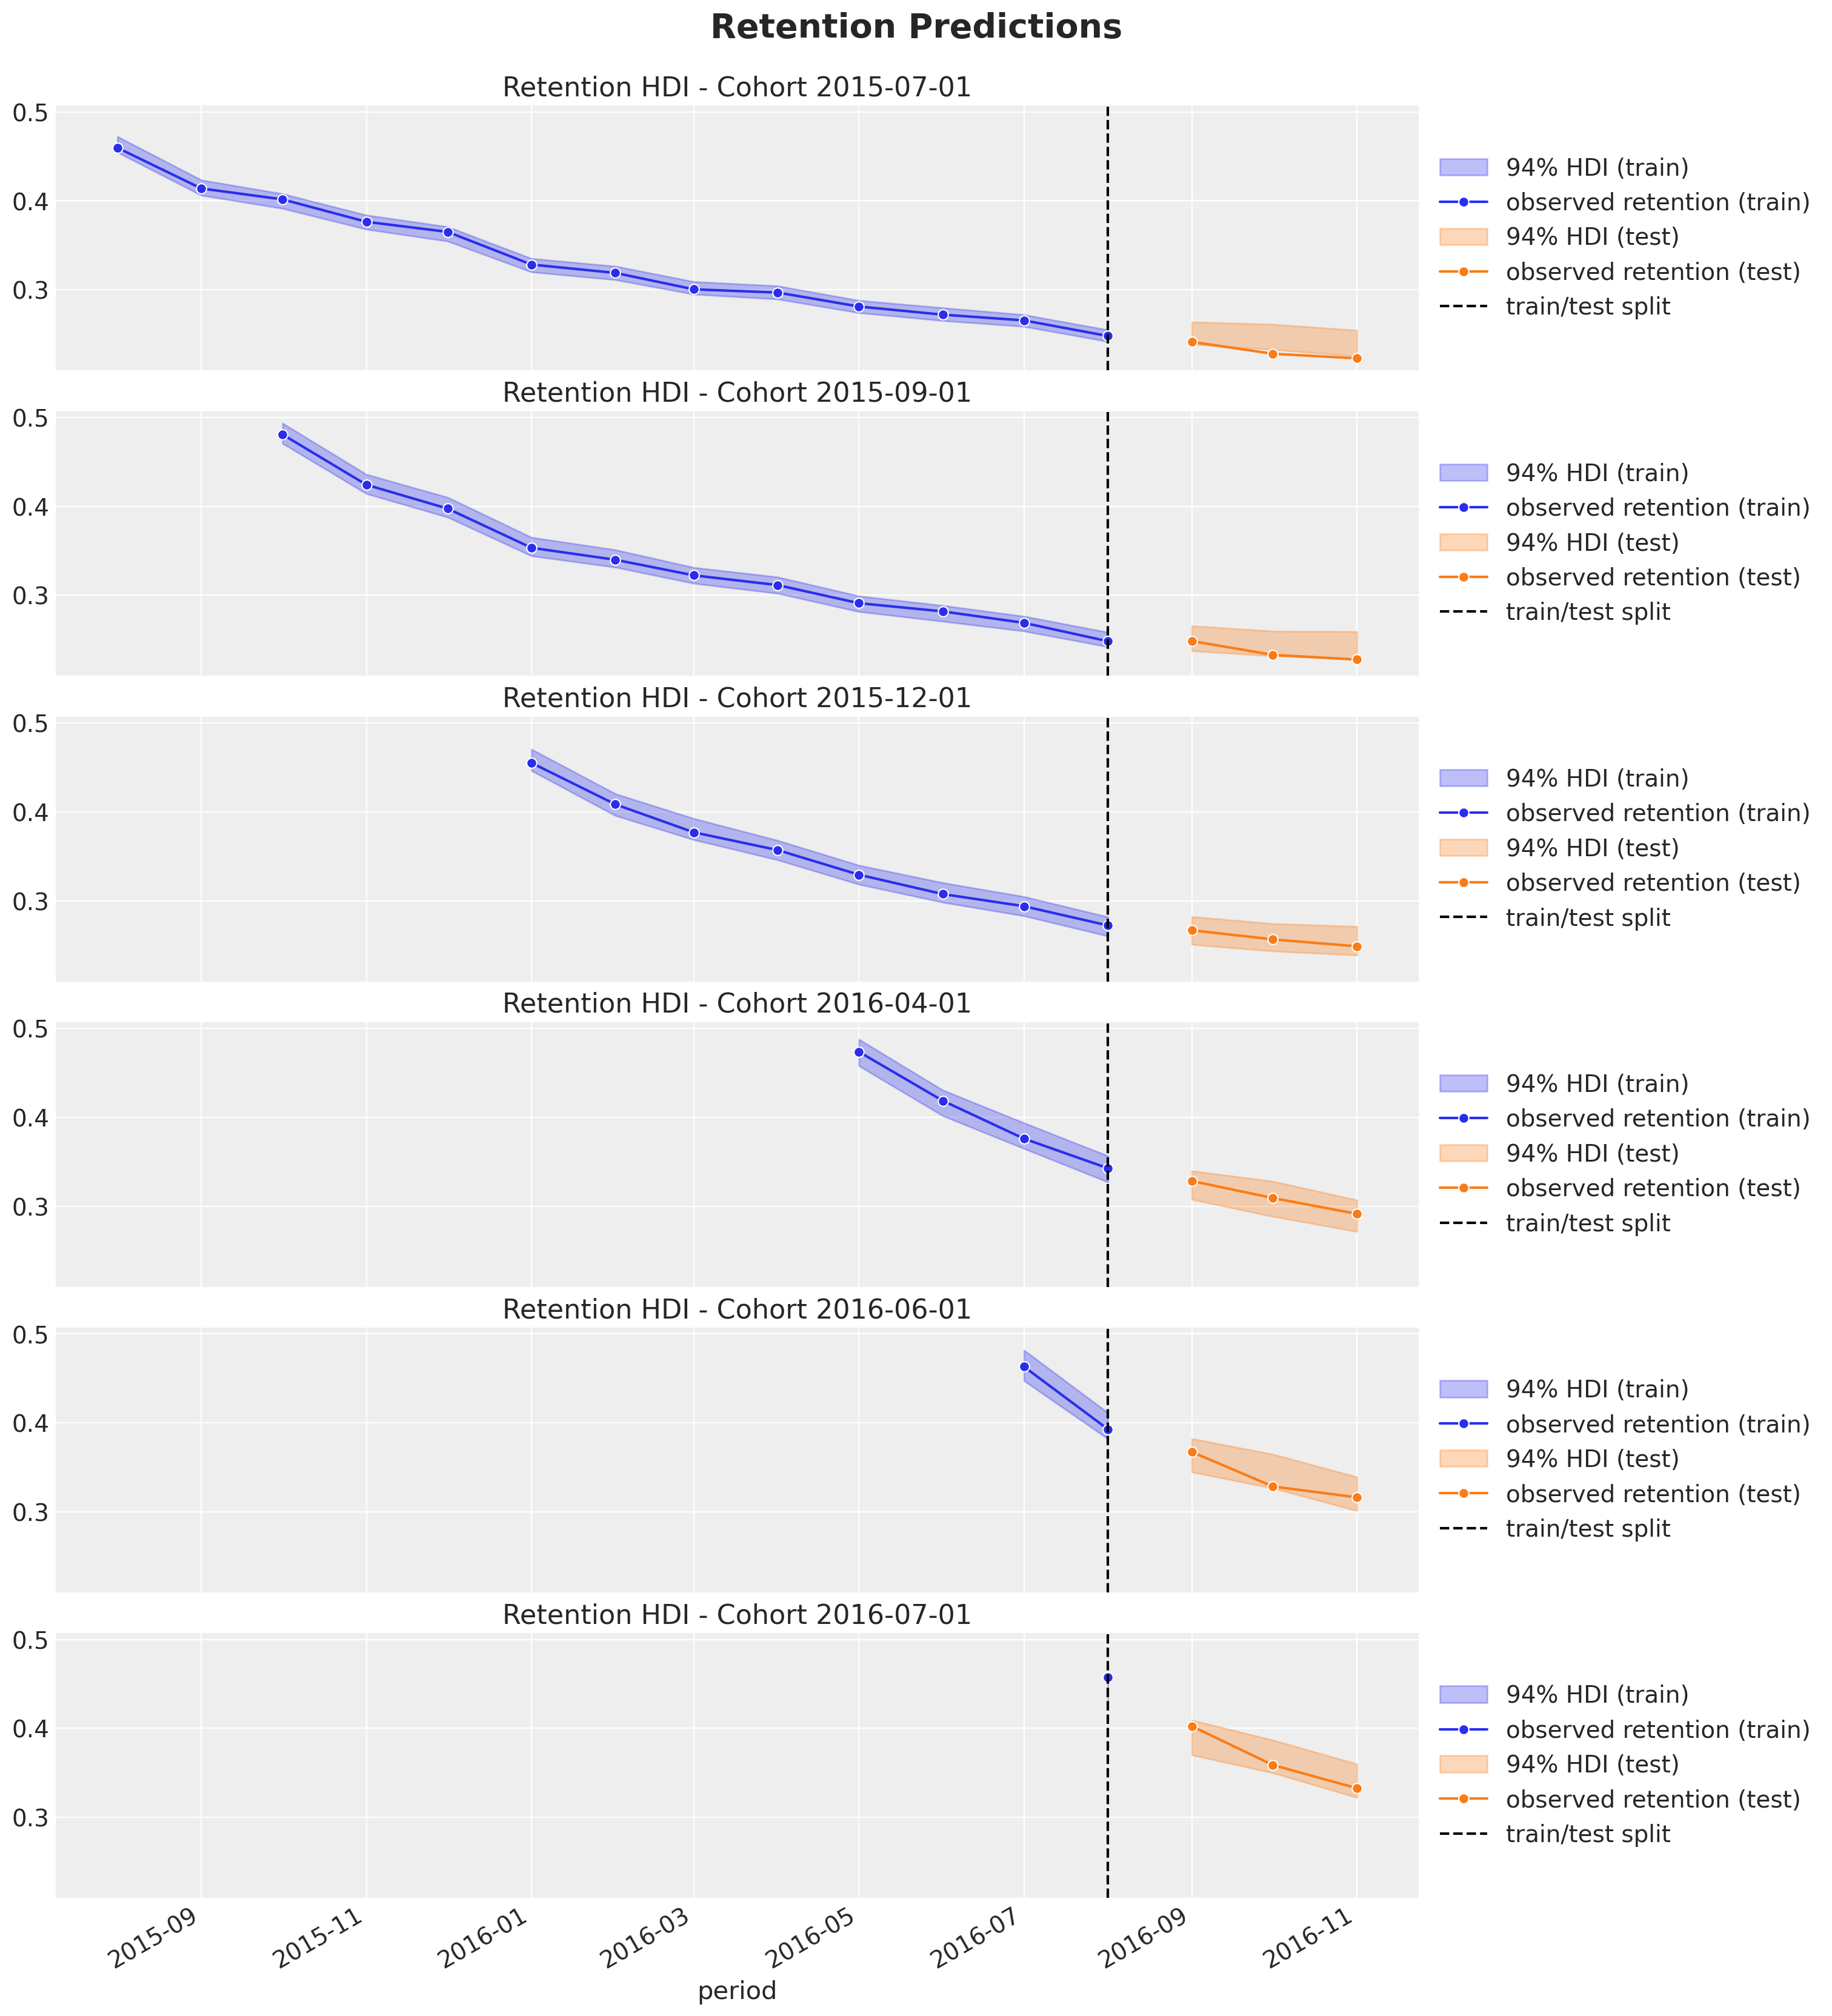

In [38]:
fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.autofmt_xdate()
fig.suptitle("Retention Predictions", y=1.03, fontsize=20, fontweight="bold");

### Machine Learning Models

In [39]:
feature_columns = [
    "cohort",
    "period",
    "revenue",
    "n_users",
    "cohort_age",
    "age",
    "cohort_month",
    "period_month",
]


ml = MLForecast(
    models=[
        HistGradientBoostingRegressor(),
    ],
    freq="1mo",
)

ml.fit(
    df=train_data_red_df[feature_columns],
    id_col="cohort",
    time_col="period",
    target_col="revenue",
    static_features=[],
)

ml_forecast = ml.predict(h=2, X_df=test_data_red_df[feature_columns])

ml_forecast.head()

shape: (5, 3)
┌────────────┬────────────┬───────────────────────────────┐
│ cohort     ┆ period     ┆ HistGradientBoostingRegressor │
│ ---        ┆ ---        ┆ ---                           │
│ date       ┆ date       ┆ f64                           │
╞════════════╪════════════╪═══════════════════════════════╡
│ 2015-07-01 ┆ 2016-09-01 ┆ 633841.605084                 │
│ 2015-07-01 ┆ 2016-10-01 ┆ 633841.605084                 │
│ 2015-08-01 ┆ 2016-09-01 ┆ 334032.988475                 │
│ 2015-08-01 ┆ 2016-10-01 ┆ 334032.988475                 │
│ 2015-09-01 ┆ 2016-09-01 ┆ 309305.925735                 │
└────────────┴────────────┴───────────────────────────────┘

In [40]:
sf = StatsForecast(
    models=[
        SimpleExponentialSmoothingOptimized(),
        AutoMFLES(test_size=3),
    ],
    freq="1mo",
)

sf_forecast = sf.forecast(
    h=3,
    df=train_data_red_df,
    id_col="cohort",
    time_col="period",
    target_col="revenue",
)

sf_forecast.head()

shape: (5, 4)
┌────────────┬────────────┬───────────────┬───────────────┐
│ cohort     ┆ period     ┆ SESOpt        ┆ AutoMFLES     │
│ ---        ┆ ---        ┆ ---           ┆ ---           │
│ date       ┆ date       ┆ f64           ┆ f64           │
╞════════════╪════════════╪═══════════════╪═══════════════╡
│ 2015-07-01 ┆ 2016-09-01 ┆ 589932.559267 ┆ 745302.219999 │
│ 2015-07-01 ┆ 2016-10-01 ┆ 589932.559267 ┆ 745302.219999 │
│ 2015-07-01 ┆ 2016-11-01 ┆ 589932.559267 ┆ 745302.219999 │
│ 2015-08-01 ┆ 2016-09-01 ┆ 340920.5062   ┆ 428699.72     │
│ 2015-08-01 ┆ 2016-10-01 ┆ 340920.5062   ┆ 428699.72     │
└────────────┴────────────┴───────────────┴───────────────┘

In [41]:
def plot_nixtla_forecast(
    forecast_df: pl.DataFrame,
    model_name: str,
    cohort_index: int,
    color: str,
    ax: plt.Axes,
) -> plt.Axes:
    cohort = train_cohort_encoder.classes_[cohort_index]

    forecast_df = forecast_df.filter(pl.col("cohort").eq(pl.lit(cohort)))

    sns.lineplot(
        data=forecast_df,
        x="period",
        y=model_name,
        marker="o",
        color=color,
        label=f"{model_name} forecast",
        ax=ax,
    )

    return ax

In [42]:
def plot_test_revenue_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.filter(
        pl.col("cohort").eq(train_cohort_encoder.classes_[cohort_index])
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_revenue_hdi[mask, :][:, 0],
        y2=test_revenue_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_revenue[mask],
        color="C1",
        marker="o",
        label="observed revenue (test)",
        ax=ax,
    )
    return ax

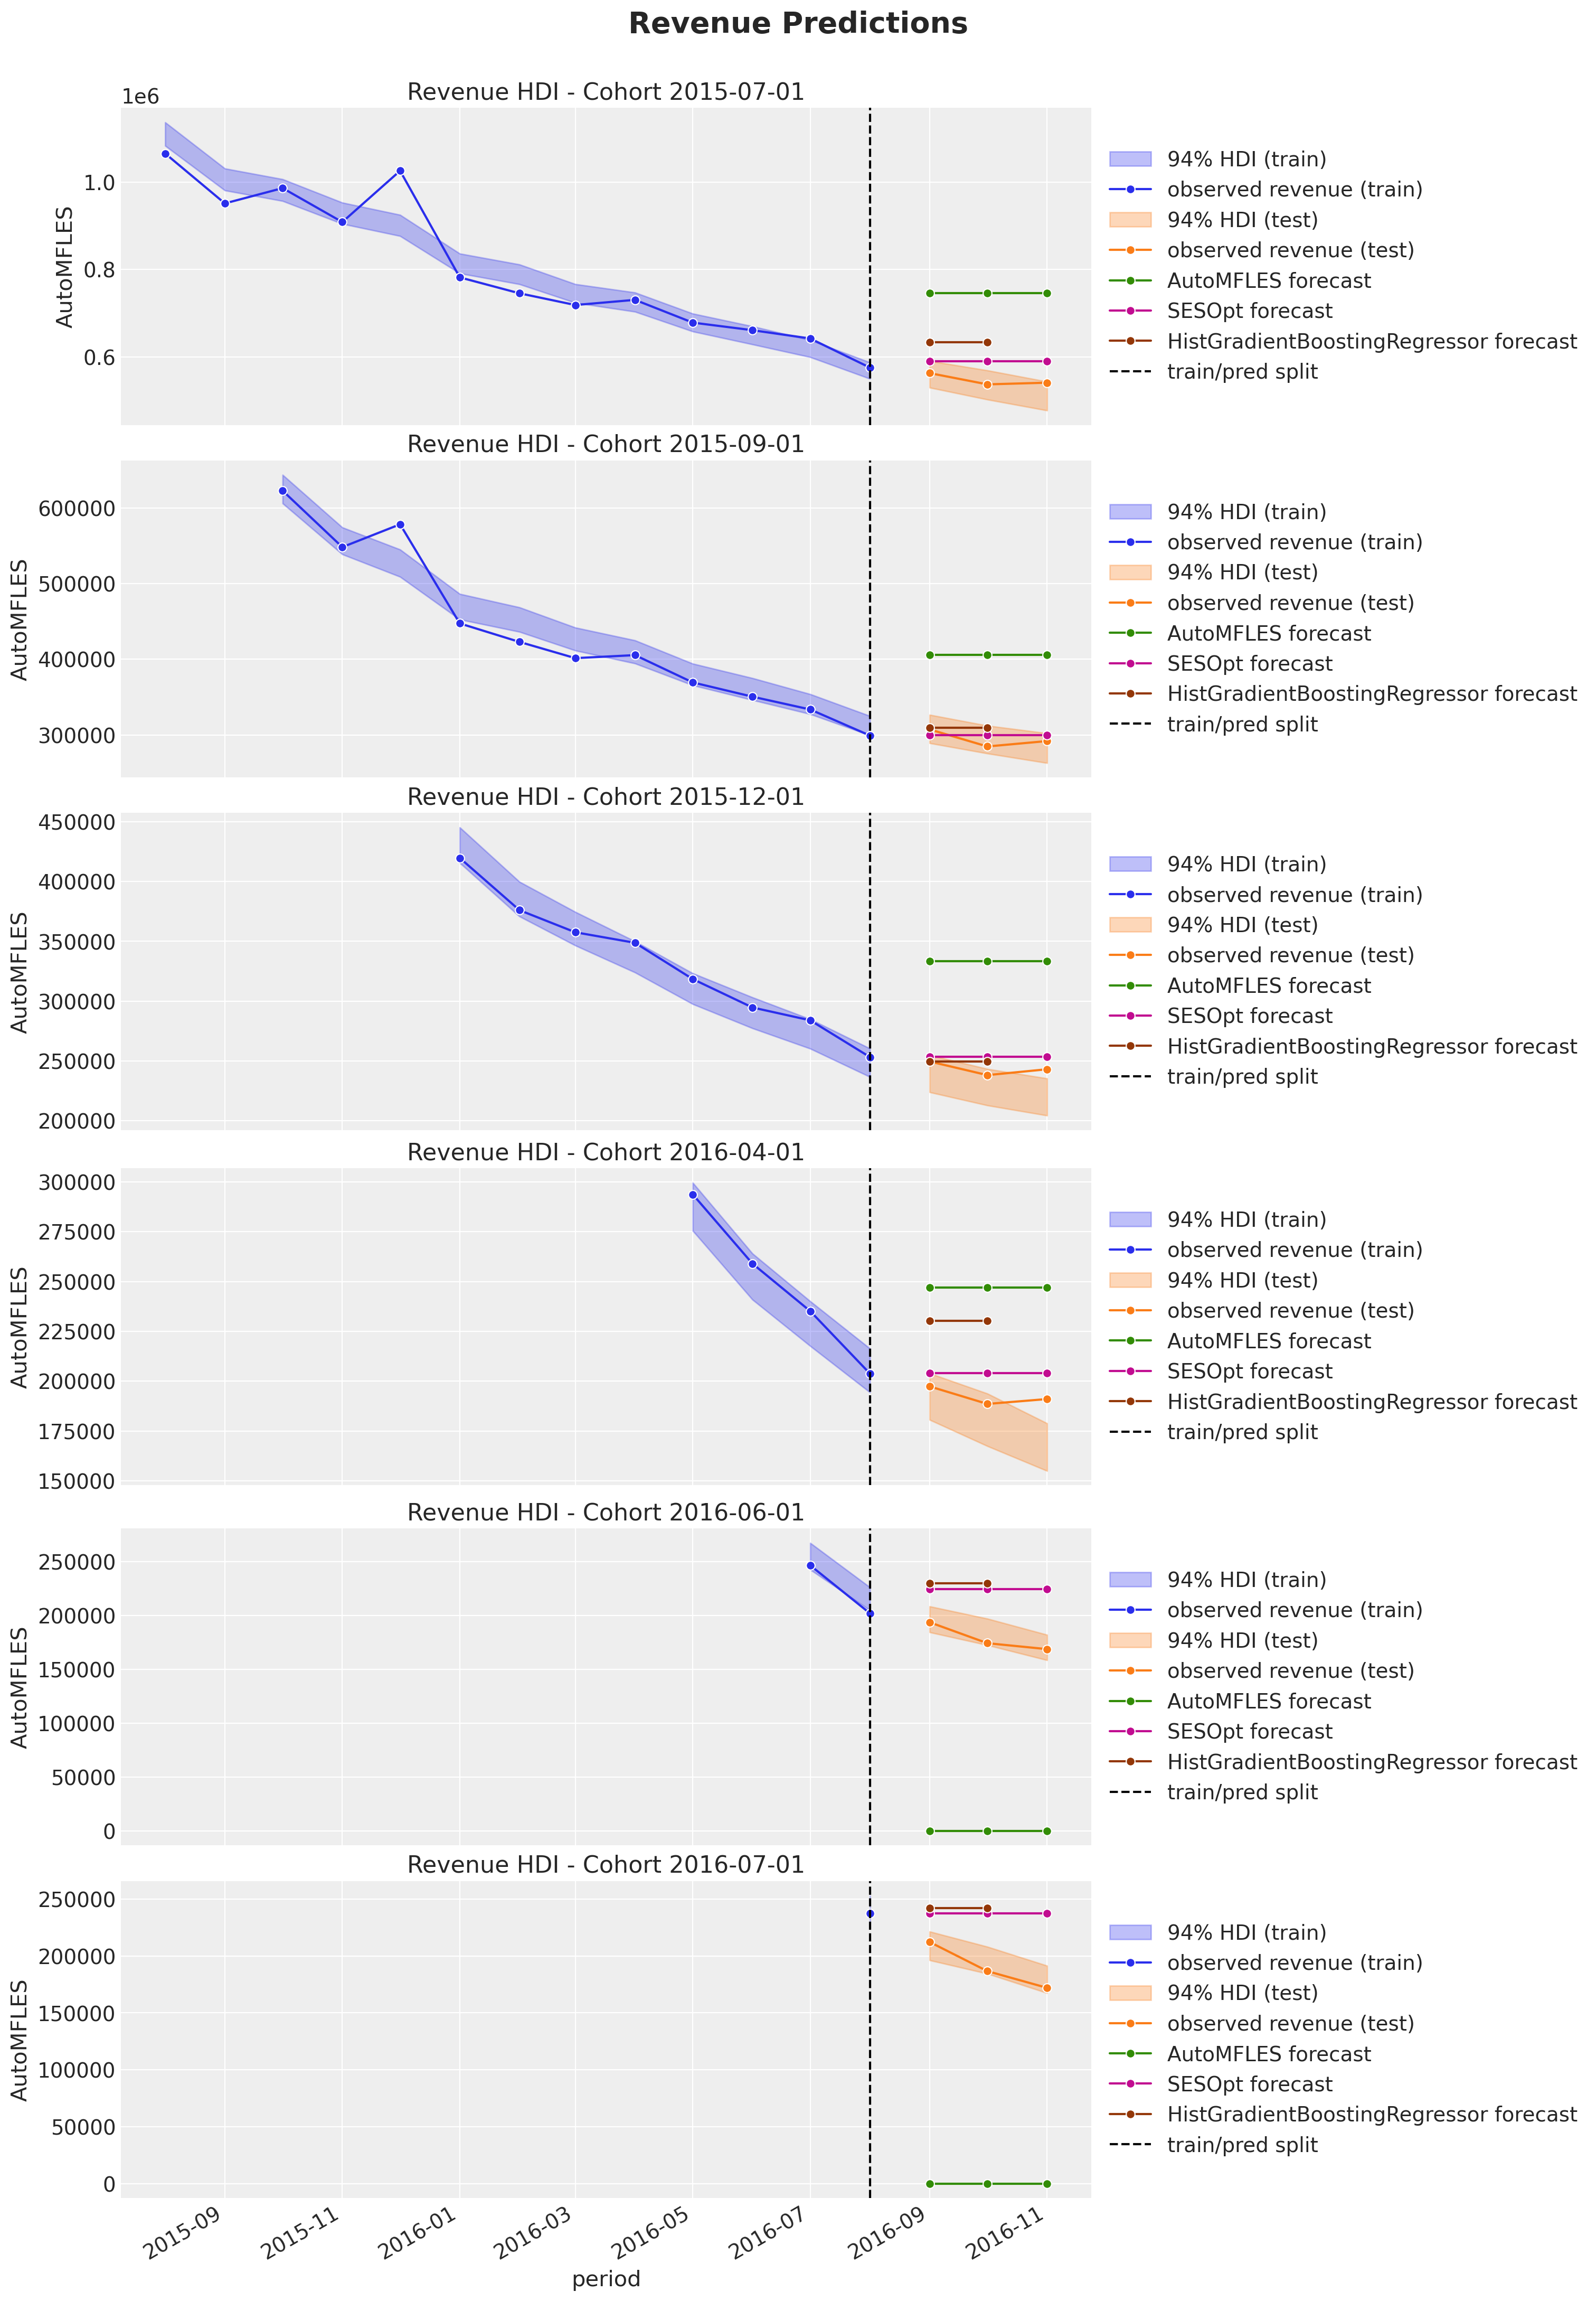

In [43]:
fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 21),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_nixtla_forecast(
        forecast_df=sf_forecast,
        model_name="AutoMFLES",
        cohort_index=cohort_index,
        color="C2",
        ax=ax,
    )
    plot_nixtla_forecast(
        forecast_df=sf_forecast,
        model_name="SESOpt",
        cohort_index=cohort_index,
        color="C3",
        ax=ax,
    )
    plot_nixtla_forecast(
        forecast_df=ml_forecast,
        model_name="HistGradientBoostingRegressor",
        cohort_index=cohort_index,
        color="C4",
        ax=ax,
    )
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/pred split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


fig.autofmt_xdate()
fig.suptitle("Revenue Predictions", y=1.03, fontsize=20, fontweight="bold");

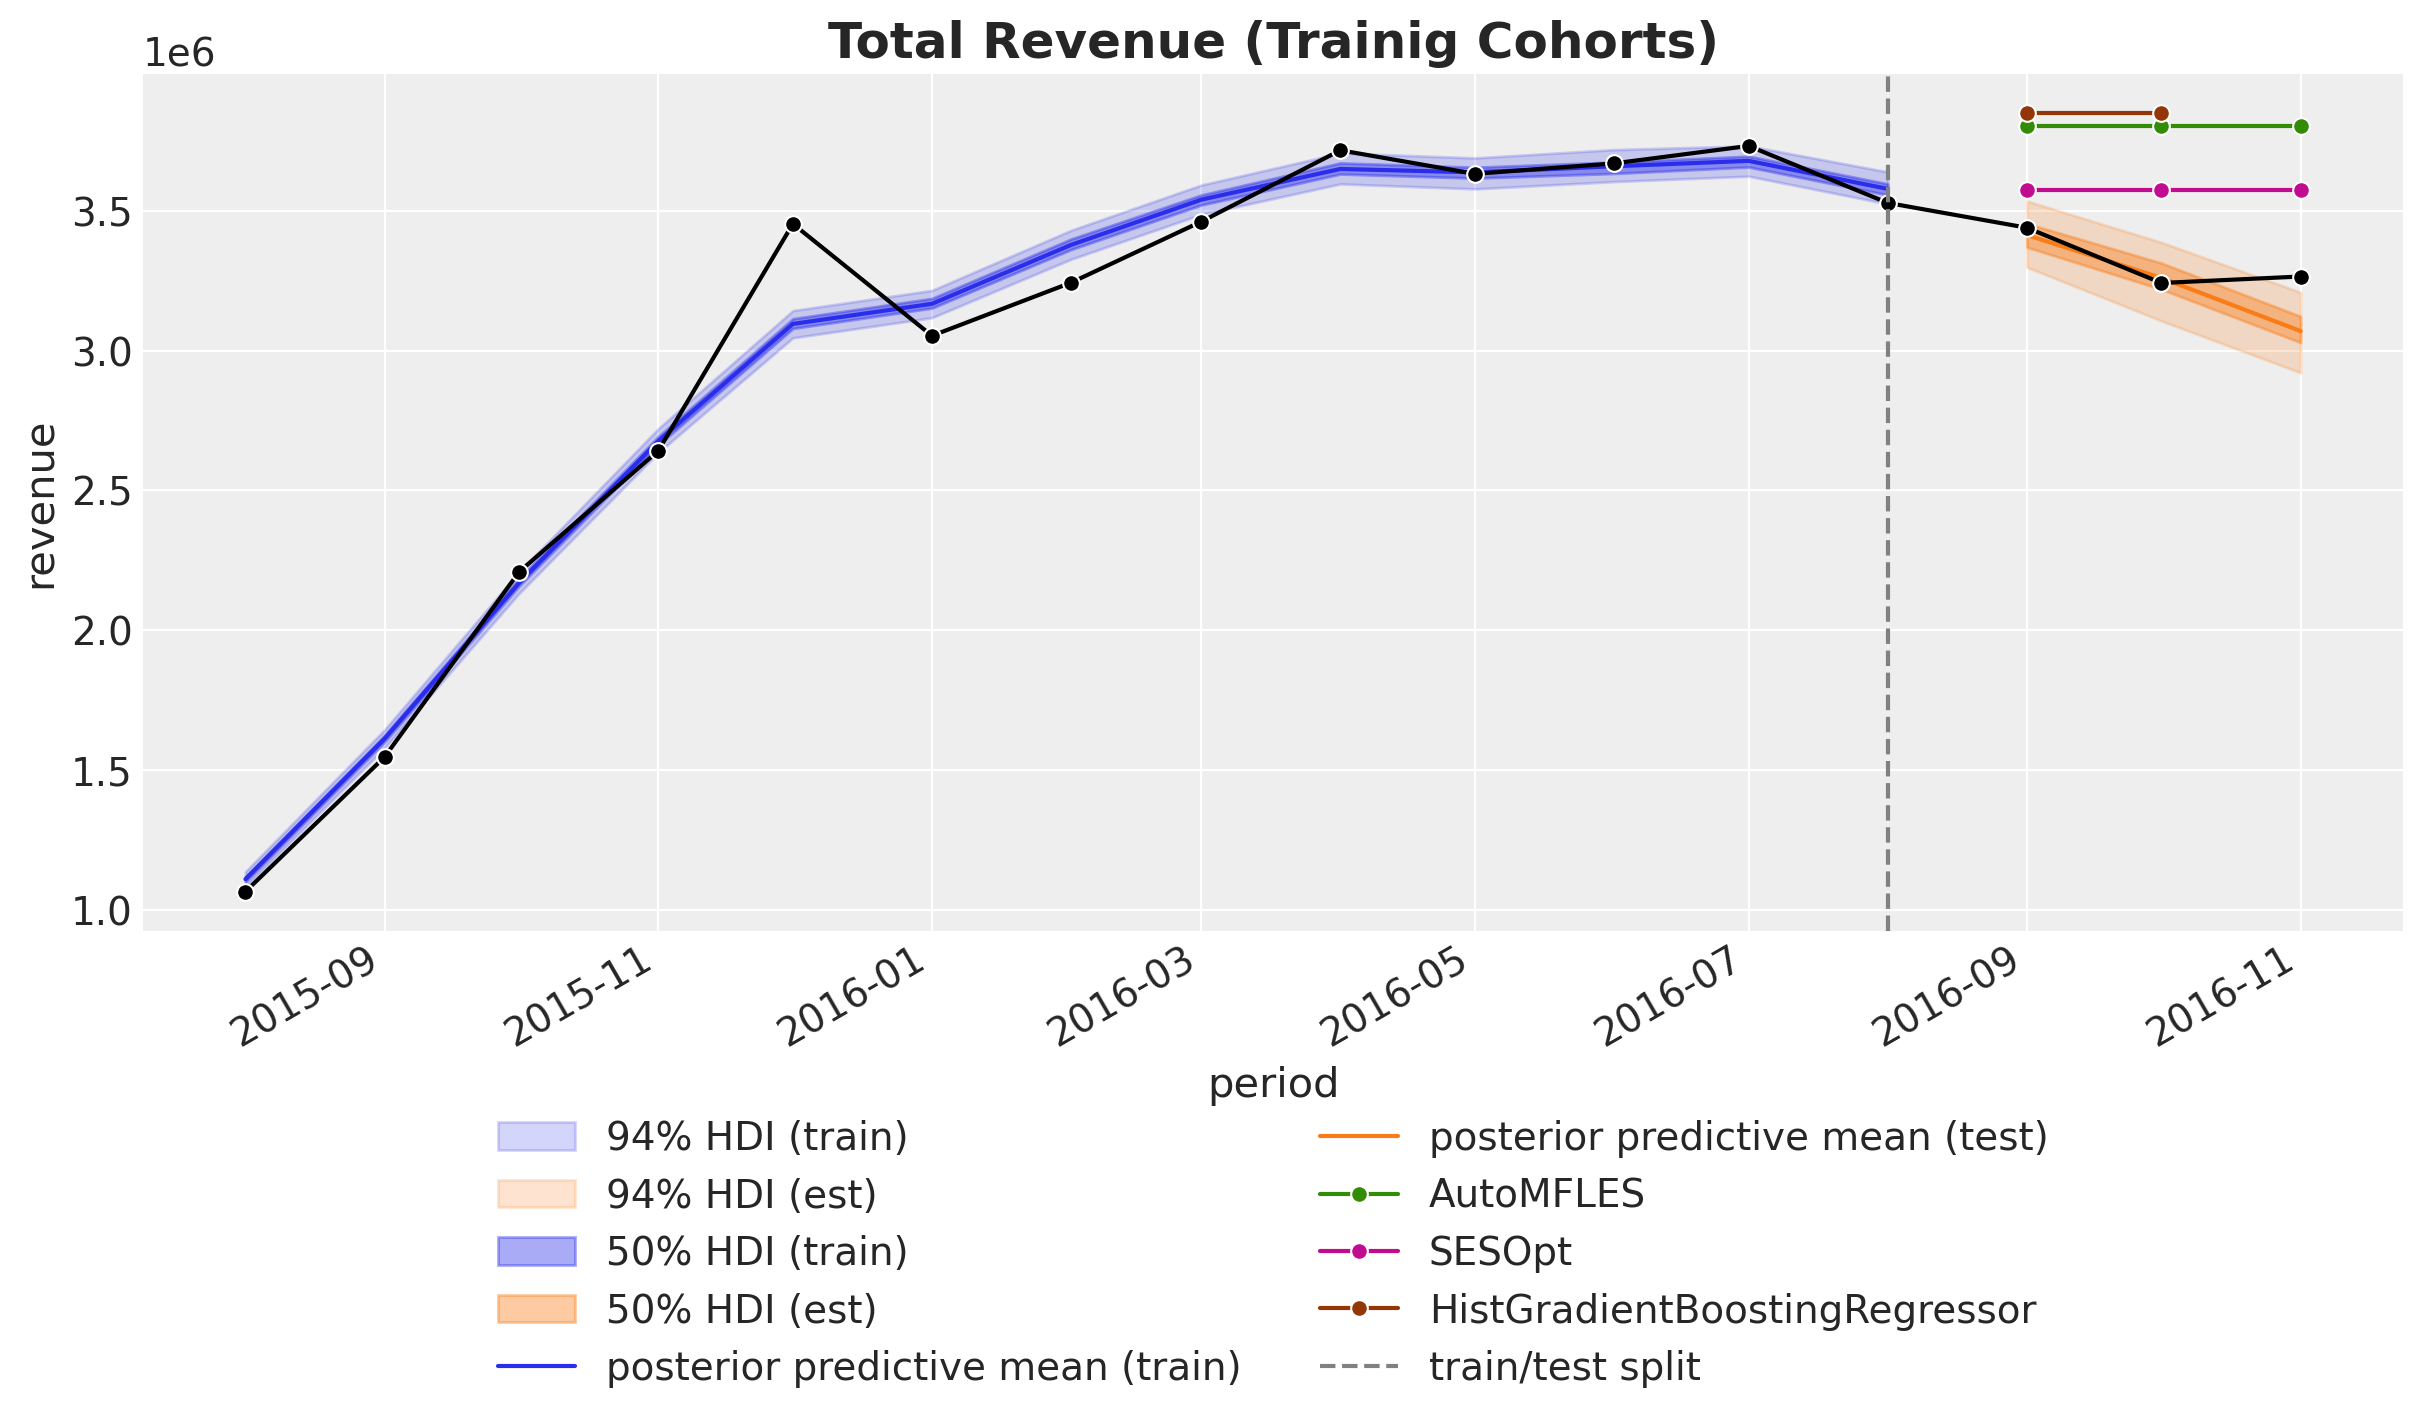

In [44]:
train_total_revenue_predicted = (
    idata["posterior_predictive"]["revenue_estimated"]
    .rename({"obs": "period_month"})
    .assign_coords(period_month=train_period)
    .groupby("period_month")
    .sum()
)

test_total_revenue_predicted = (
    idata_oos["posterior_predictive"]["revenue_estimated"]
    .rename({"obs": "period_month"})
    .assign_coords(period_month=test_period)
    .groupby("period_month")
    .sum()
)

ml_forecast_agg = ml_forecast.group_by("period").sum()
sf_forecast_agg = sf_forecast.group_by("period").sum()


fig, ax = plt.subplots()

for i, hdi_prob in enumerate([0.94, 0.5]):
    az.plot_hdi(
        x=train_total_revenue_predicted.coords["period_month"],
        y=train_total_revenue_predicted,
        hdi_prob=hdi_prob,
        color="C0",
        smooth=False,
        fill_kwargs={"alpha": 0.2 * (i + 1), "label": f"{hdi_prob:.0%} HDI (train)"},
        ax=ax,
    )

    az.plot_hdi(
        x=test_total_revenue_predicted.coords["period_month"],
        y=test_total_revenue_predicted,
        hdi_prob=hdi_prob,
        color="C1",
        smooth=False,
        fill_kwargs={"alpha": 0.2 * (i + 1), "label": f"{hdi_prob:.0%} HDI (est)"},
        ax=ax,
    )


ax.plot(
    train_total_revenue_predicted.coords["period_month"],
    train_total_revenue_predicted.mean(dim=["chain", "draw"]),
    color="C0",
    label="posterior predictive mean (train)",
)

ax.plot(
    test_total_revenue_predicted.coords["period_month"],
    test_total_revenue_predicted.mean(dim=["chain", "draw"]),
    color="C1",
    label="posterior predictive mean (test)",
)

(
    cohort_df.filter(pl.col("cohort_age").gt(pl.lit(0)))
    .filter(pl.col("cohort").is_in(set(train_data_red_df["cohort"])))
    .group_by("period")
    .agg(pl.col("revenue").sum())
    .pipe(
        sns.lineplot,
        x="period",
        y="revenue",
        color="black",
        marker="o",
        ax=ax,
    )
)

sns.lineplot(
    data=sf_forecast_agg,
    x="period",
    y="AutoMFLES",
    color="C2",
    marker="o",
    label="AutoMFLES",
    ax=ax,
)

sns.lineplot(
    data=sf_forecast_agg,
    x="period",
    y="SESOpt",
    color="C3",
    marker="o",
    label="SESOpt",
    ax=ax,
)

sns.lineplot(
    data=ml_forecast_agg,
    x="period",
    y="HistGradientBoostingRegressor",
    color="C4",
    marker="o",
    label="HistGradientBoostingRegressor",
    ax=ax,
)

ax.axvline(
    x=period_train_test_split,
    color="gray",
    linestyle="--",
    label="train/test split",
)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=2)
fig.autofmt_xdate()
ax.set_title("Total Revenue (Trainig Cohorts)", fontsize=18, fontweight="bold");

## Evaluation Metrics

We compute quantitative evaluation metrics to compare the Bayesian model against the baseline time series and machine learning models.

In [45]:
# Align baseline predictions with test data
test_cohorts = test_data_red_df["cohort"].unique().to_list()
test_periods = test_data_red_df["period"].unique().to_list()

# Filter forecasts to match test data structure
sf_forecast_aligned = sf_forecast.filter(
    pl.col("cohort").is_in(test_cohorts) & pl.col("period").is_in(test_periods)
).sort(["cohort", "period"])

ml_forecast_aligned = ml_forecast.filter(
    pl.col("cohort").is_in(test_cohorts) & pl.col("period").is_in(test_periods)
).sort(["cohort", "period"])

# Ensure test data is sorted consistently
test_data_sorted = test_data_red_df.sort(["cohort", "period"])

# Get actual test revenue values
test_revenue_actual = test_data_sorted["revenue"].to_numpy()

# Bayesian model: posterior predictive mean
# Need to align with sorted test data
bayesian_pred = (
    az.extract(idata_oos["posterior_predictive"], var_names=["revenue_estimated"])
    .mean("sample")
    .to_numpy()
)

# Baseline predictions
automfles_pred = sf_forecast_aligned["AutoMFLES"].to_numpy()
ses_pred = sf_forecast_aligned["SESOpt"].to_numpy()
hgb_pred = ml_forecast_aligned["HistGradientBoostingRegressor"].to_numpy()


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, model_name: str) -> dict:
    """Compute evaluation metrics for a model."""
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        "Model": model_name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2),
    }


# Compute metrics for each model
metrics_list = [
    compute_metrics(test_revenue_actual, bayesian_pred, "Bayesian (BART)"),
    compute_metrics(test_revenue_actual, automfles_pred, "AutoMFLES"),
    compute_metrics(test_revenue_actual, ses_pred, "SES"),
    compute_metrics(test_revenue_actual, hgb_pred, "HistGradientBoostingRegressor"),
]

metrics_df = pd.DataFrame(metrics_list)

# HDI Coverage for Bayesian model
coverage = (
    np.mean(
        (test_revenue_actual >= test_revenue_hdi[:, 0])
        & (test_revenue_actual <= test_revenue_hdi[:, 1])
    )
    * 100
)

print(f"Bayesian 94% HDI Coverage: {coverage:.1f}%")
print()
metrics_df

ValueError: operands could not be broadcast together with shapes (39,) (26,) 

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w